# Evaluating the CPP scheme
Here, the version CPP2.17 is used, which only perturbs w, no u or v perturbations, and considers surface theta-v gradients. 
1. We describe some conceptual aspects. 
2. We consider example fields on 5th June for precipitation, theta-v, vertical velocity, fields to describe gust front mask, ...
3. We evaluate the impact on the whole period via some quantitative metrics

In [1]:
from enstools.io import read
from enstools.plot import contour
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import pandas as pd
import xarray as xr
import numpy as np
import dask
import seaborn as sns
import logging
import cartopy.crs as ccrs
import cartopy.feature as cf
from tqdm import tqdm
from misc_functions import my_contour
from misc_functions import get_radar_mask
from misc_functions import get_prec_time
from misc_functions import compute_theta_v
from misc_functions import get_color_and_lw
from misc_functions import get_data
from misc_functions import get_prec_data, plot_prec_fields
#dfdf
homedir = '/home/m/M.Hirt/'


plt.style.use(['seaborn-colorblind', '/home/m/M.Hirt/poster.mplstyle'])
#matplotlib widget
logger = logging.getLogger()
logger.setLevel(logging.INFO)




In [2]:
import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = [5,5]

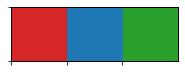

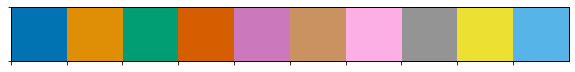

In [3]:
current_palette = sns.color_palette('tab10')
grid_colors =[ current_palette[i] for i in [3,0,2]]
secondary_colors= sns.color_palette('colorblind')#[sns.color_palette('deep')[i] for i in [3,9,8,2,1,0,4,6,7]]

sns.palplot(grid_colors)
sns.palplot(secondary_colors)

# Conceptual

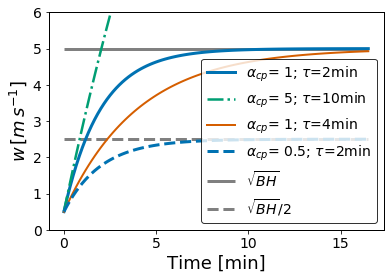

In [4]:
import matplotlib as mpl
%matplotlib inline
#plt.xkcd()
mpl.style.use('seaborn-colorblind')
plt.figure(figsize=[6,4])
t = np.arange(0,1000,10)/60
w0=5
tau =60*2
wg=0.5
w = (wg-w0)*np.exp(-t*60/tau) + w0
plt.hlines(w0, t.min(), t.max(), label =r'$\sqrt{BH}$', linewidth=3, color='grey', linestyle='-')
plt.hlines(w0/2., t.min(), t.max(),label =r'$\sqrt{BH}$/2', color='grey', linewidth=3, linestyle='--',)

plt.plot(t,w, label=r'$\alpha_{cp}$= 1; $\tau$=2min', linewidth=3)
plt.xlabel('Time [min]'); plt.ylabel(r'$w\,[m\,s^{-1}]$')


tau =60*10
w0=25
w = (wg-w0)*np.exp(-t*60/tau) + w0
plt.plot(t,w, label=r'$\alpha_{cp}$= 5; $\tau$=10min', linewidth=2.5, linestyle='-.')

tau =60*4
w0=5
w = (wg-w0)*np.exp(-t*60/tau) + w0
plt.plot(t,w, label=r'$\alpha_{cp}$= 1; $\tau$=4min', linewidth=2)

tau =60*2
w0=5
w = (wg-w0/2.)*np.exp(-t*60/tau) + w0/2
plt.plot(t,w, label=r'$\alpha_{cp}$= 0.5; $\tau$=2min', linewidth=3, color = sns.color_palette()[0], linestyle='--')
#plt.grid()

plt.ylim([0,6])
leg = plt.legend(loc = 'lower right')
leg.get_frame().set_alpha(0.8)
plt.savefig('../Figures/Paper/schematic_time_evolution_perturbations.pdf')

# Impact on 5 June 

## Impact on Precipitation 

In [5]:
from misc_functions import get_prec_data, plot_prec_fields
date='20160605'

run_list =  ['reference',
                   #'cpp2.17_tanh_a1.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                   'cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                   'cpp2.17_tanh_a2.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                    #'PSP2a0.8_cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
             'radar']


prec_arrays = get_prec_data(run_names = run_list, date = date)
radar_mask = get_radar_mask(date=date, use_time_dependent=False)   

100%|██████████| 4/4 [00:06<00:00,  1.43s/it]


In [6]:
run_list = ['reference',  r'CPP; $\alpha$=1.2', r'CPP; $\alpha$=2.0', 'radar']
#prec_arrays= prec_arrays.rename({'cpp2.17_tanh_a1.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0':'CPP; a=1'})
prec_arrays= prec_arrays.rename({'cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0':r'CPP; $\alpha$=1.2'})
prec_arrays= prec_arrays.rename({'cpp2.17_tanh_a2.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0':r'CPP; $\alpha$=2.0'})
#prec_arrays= prec_arrays.rename({'cpp2.17_tanh_a3.0_wmax0.6_kref38_theta1.5_sso50.0_tau300.0_dh500.0_h01500.0':'CPP; a=2.0'})
prec_arrays

<xarray.Dataset>
Dimensions:            (rlat: 461, rlon: 421, time: 24)
Coordinates:
    rotated_pole       |S1 b''
  * rlon               (rlon) float32 -5.0 -4.975 -4.95 ... 5.45 5.475 5.5
  * rlat               (rlat) float32 -5.0 -4.975 -4.95 ... 6.45 6.475 6.5
    lon                (rlat, rlon) float32 2.9758525 3.0107758 ... 19.840677
    lat                (rlat, rlon) float32 44.76518 44.767513 ... 56.137974
    height_2m          float32 2.0
    height_10m         float32 10.0
    height_toa         float32 22000.0
    wbt_13c            float32 1.3
  * time               (time) datetime64[ns] 2016-06-05T01:00:00 ... 2016-06-06
Data variables:
    reference          (time, rlat, rlon) float32 0.0 2.514567e-13 ... 0.0 0.0
    CPP; $\alpha$=1.2  (time, rlat, rlon) float32 0.0 2.514567e-13 ... 0.0 0.0
    CPP; $\alpha$=2.0  (time, rlat, rlon) float32 0.0 2.514567e-13 ... 0.0 0.0
    radar              (time, rlat, rlon) float32 dask.array<shape=(24, 461, 421), chunksize=(1, 461

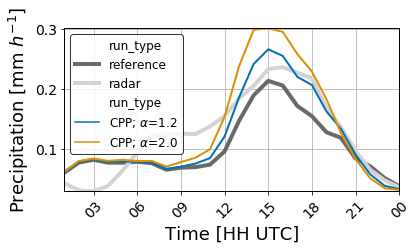

In [7]:

df = prec_arrays.where(radar_mask).mean(['rlon','rlat']).to_dataframe()[run_list]
df = df.stack().reset_index()
df = df.rename(columns={'level_1':'run_type', 0:'precipitation'})

refrad_runs =  ['reference', 'radar']
colors, linewidths = get_color_and_lw(refrad_runs, prec_arrays)
plt.figure(figsize=[6,3])
sns.lineplot(x = 'time', y = 'precipitation', hue='run_type', data = df, hue_order=refrad_runs,#legend=False,
            palette=colors, size='run_type', sizes= linewidths, size_order =refrad_runs)

sns.lineplot(x = 'time', y = 'precipitation',
             hue='run_type',
             data = df[df['run_type'].isin(run_list[1:3])], 
             palette=sns.color_palette("colorblind", 2),#[::-1],
            linewidth=2)


#leg = plt.legend(loc='lower left' , ncol=2, fontsize=12., bbox_to_anchor=[1.,0.02])
leg = plt.legend(loc='upper left' , ncol=1, fontsize=12)
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel(r'Precipitation [mm $h^{-1}$]')
plt.xlabel('Time [HH UTC]')
plt.grid()
plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
plt.gca().autoscale(tight=True)
#plt.savefig('../Figures/Paper/precip_ts_alpha.pdf')

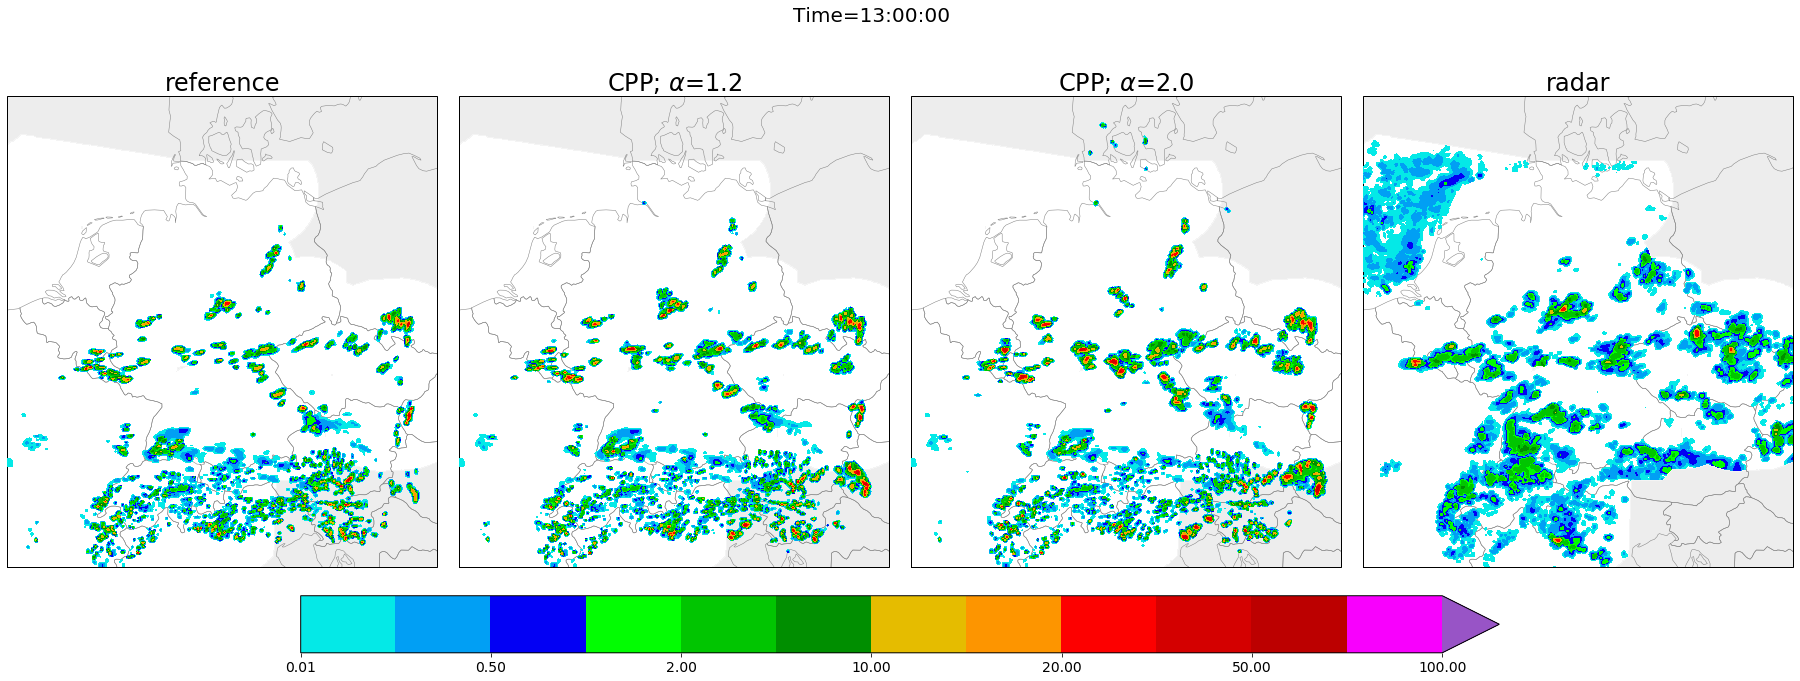

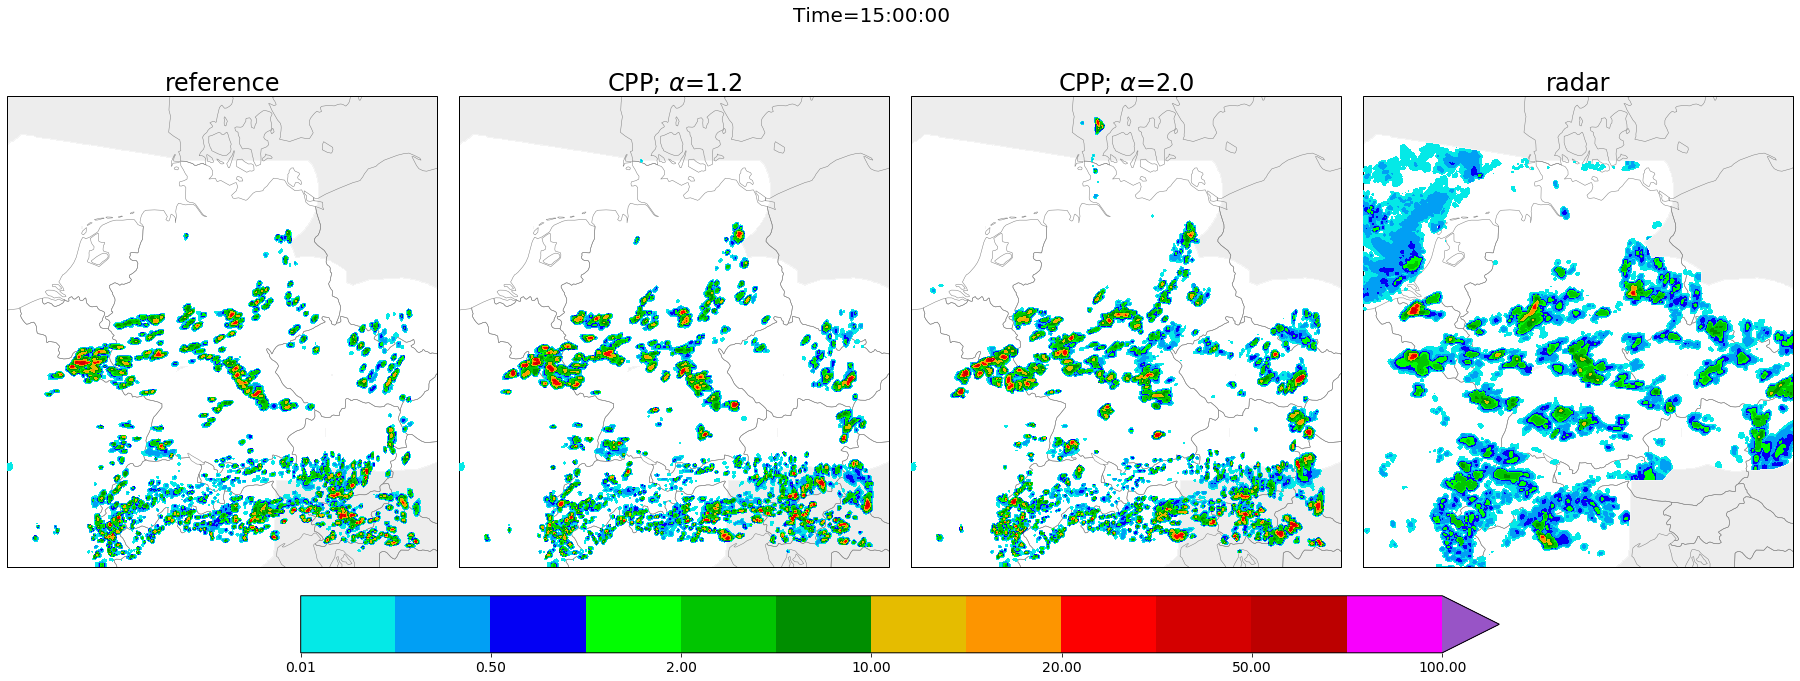

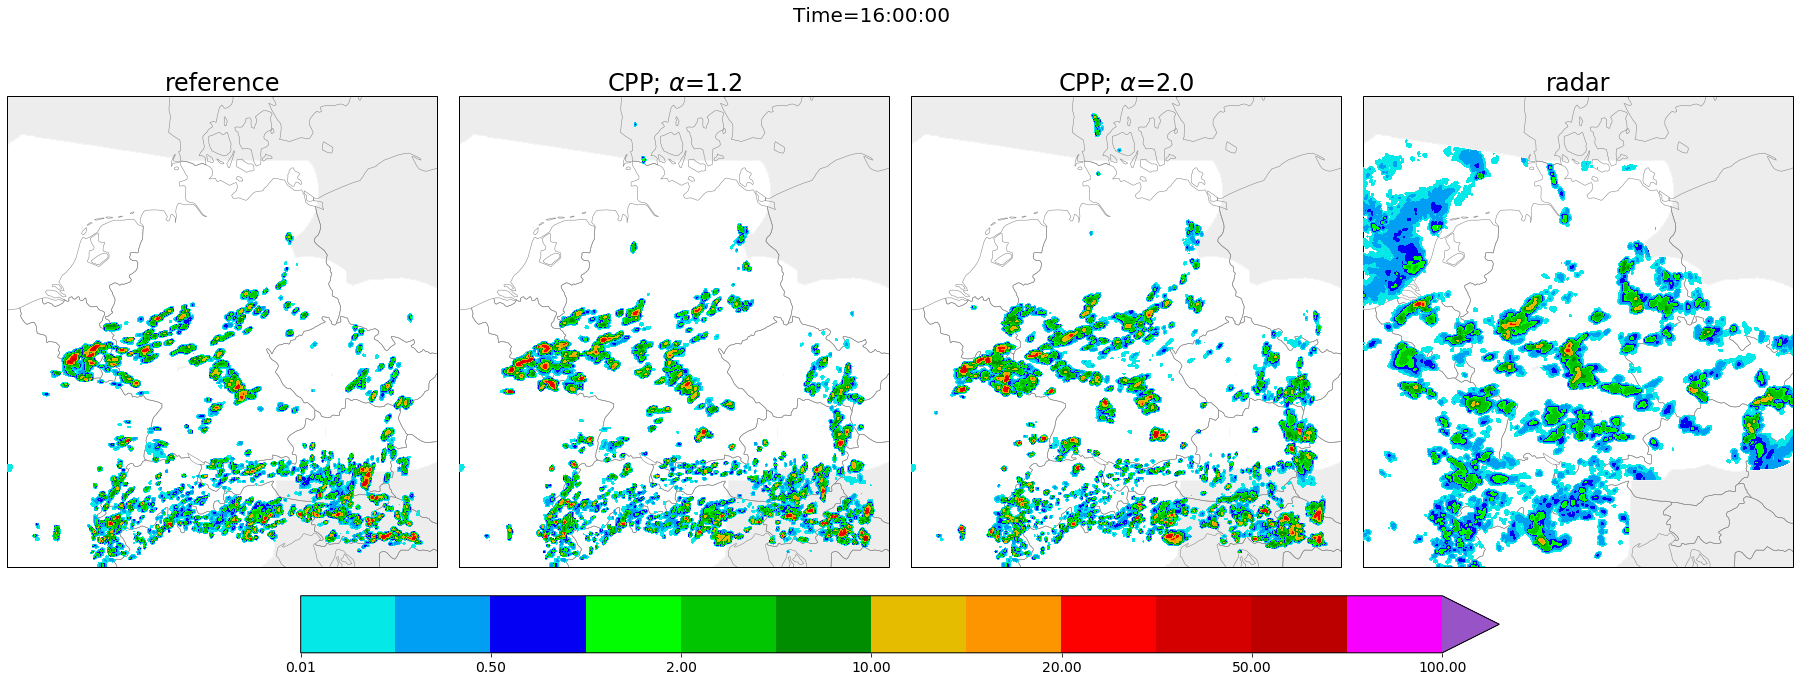

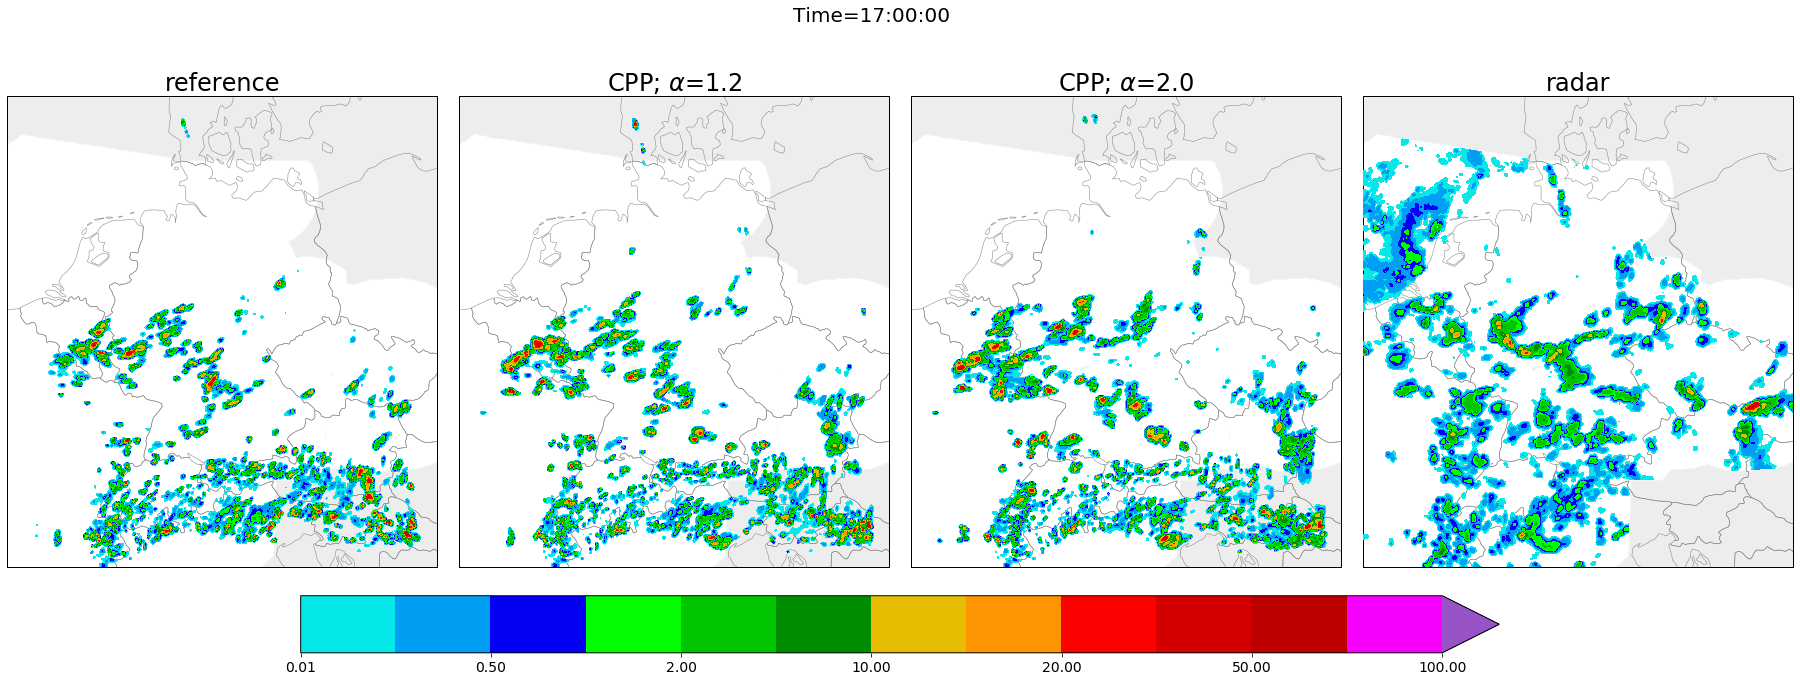

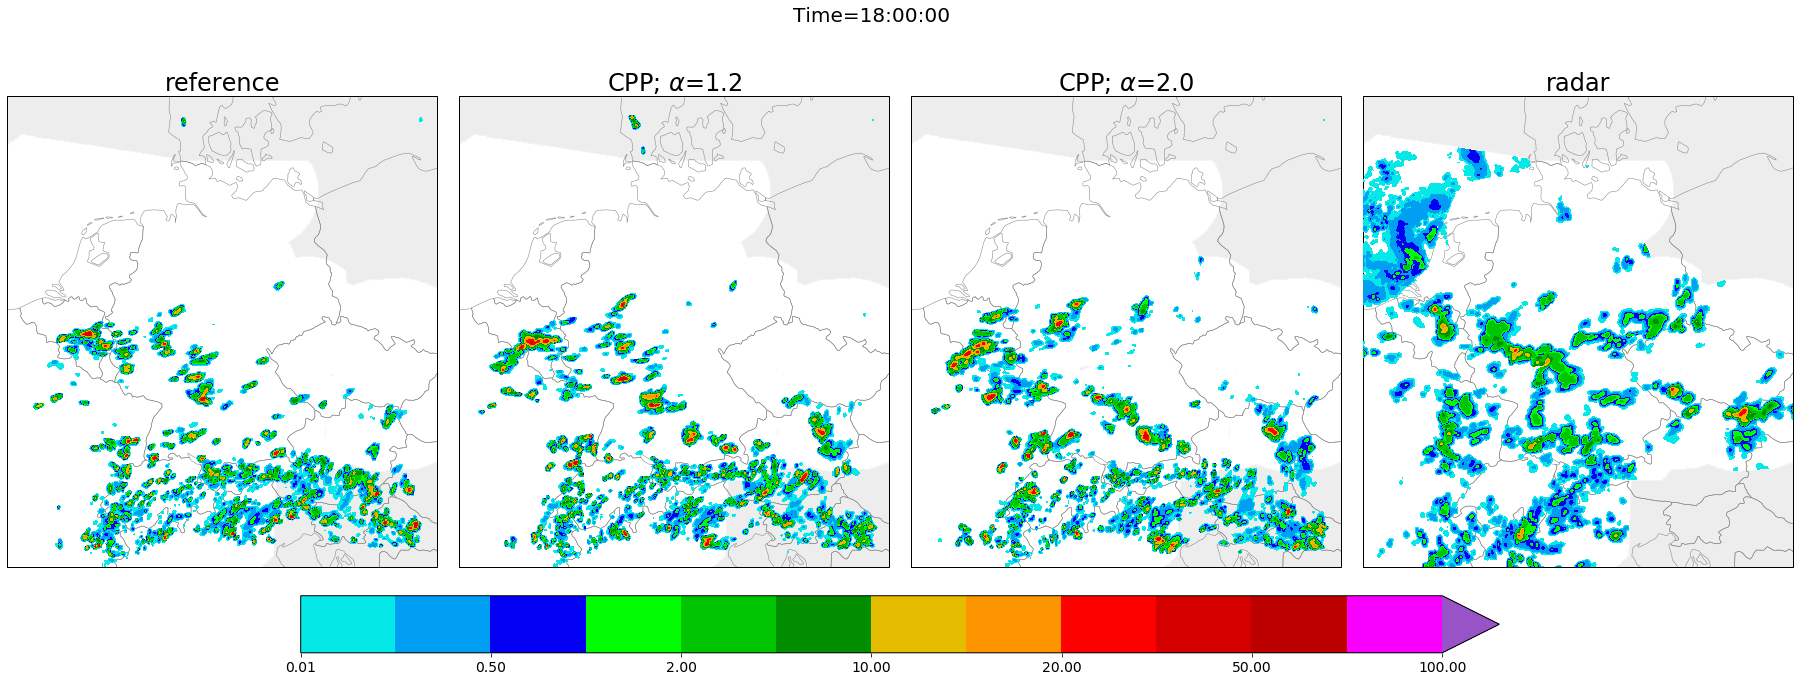

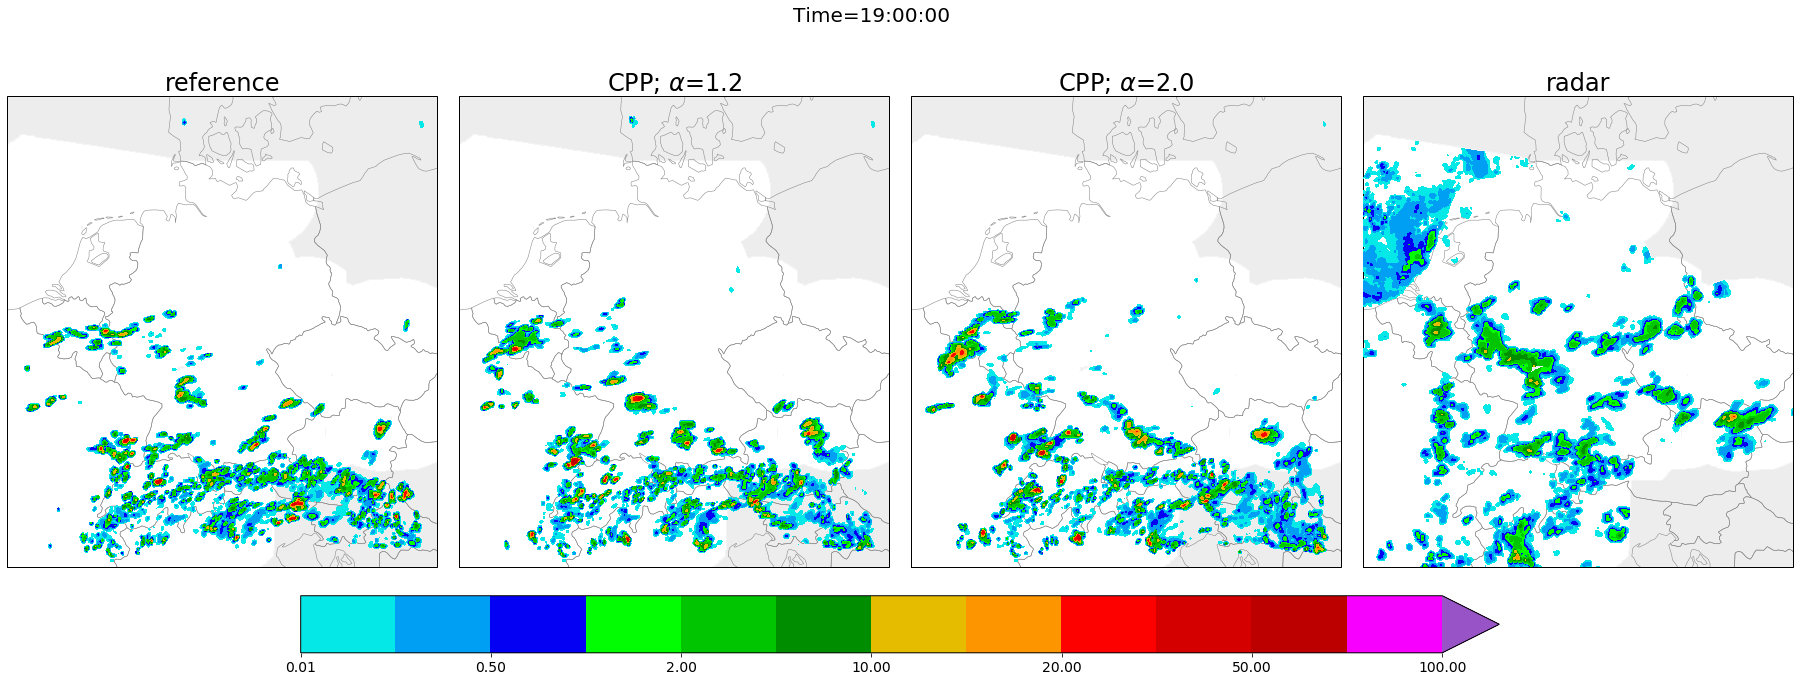

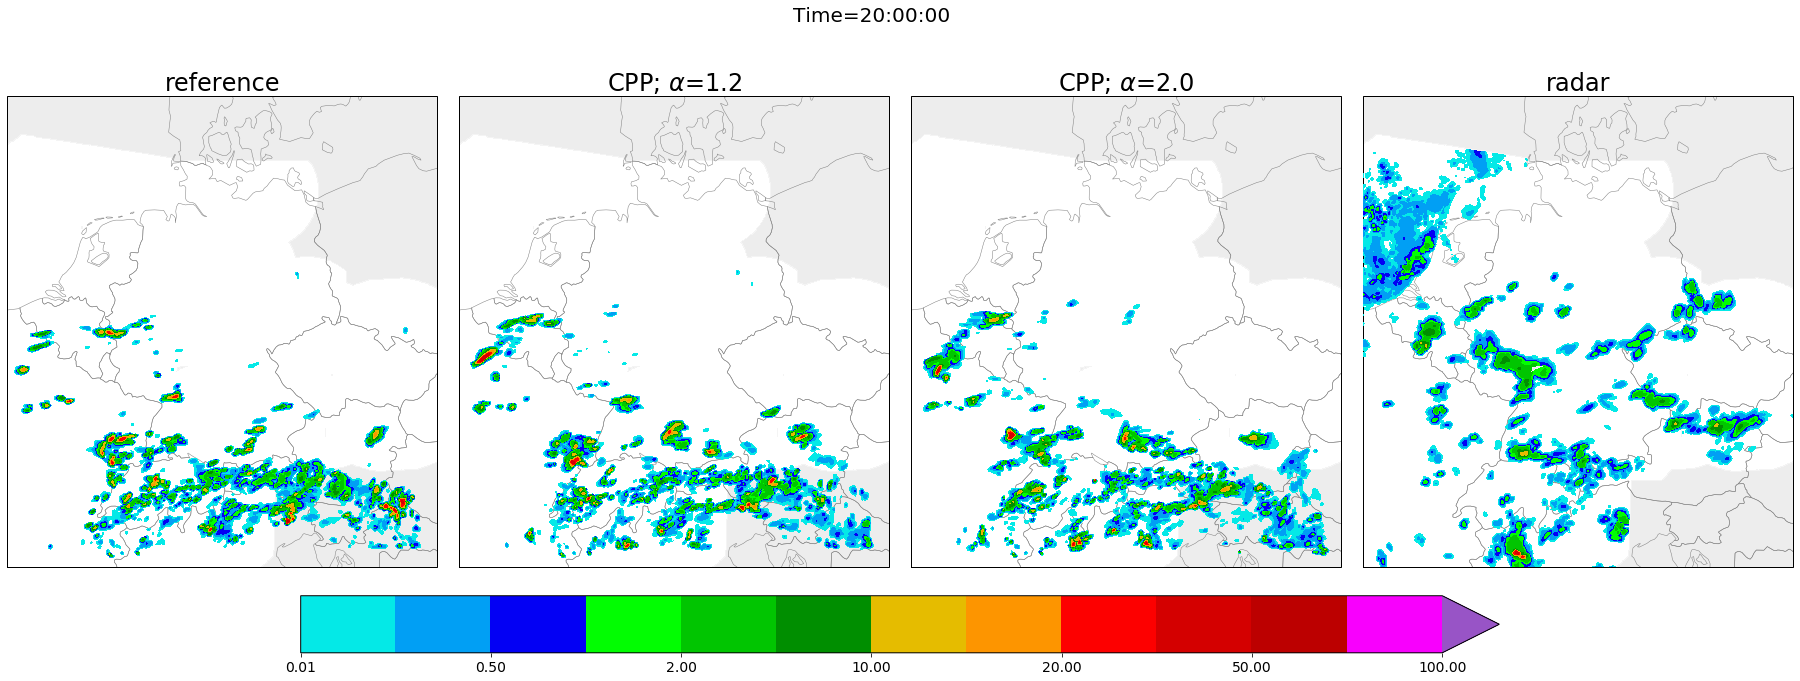

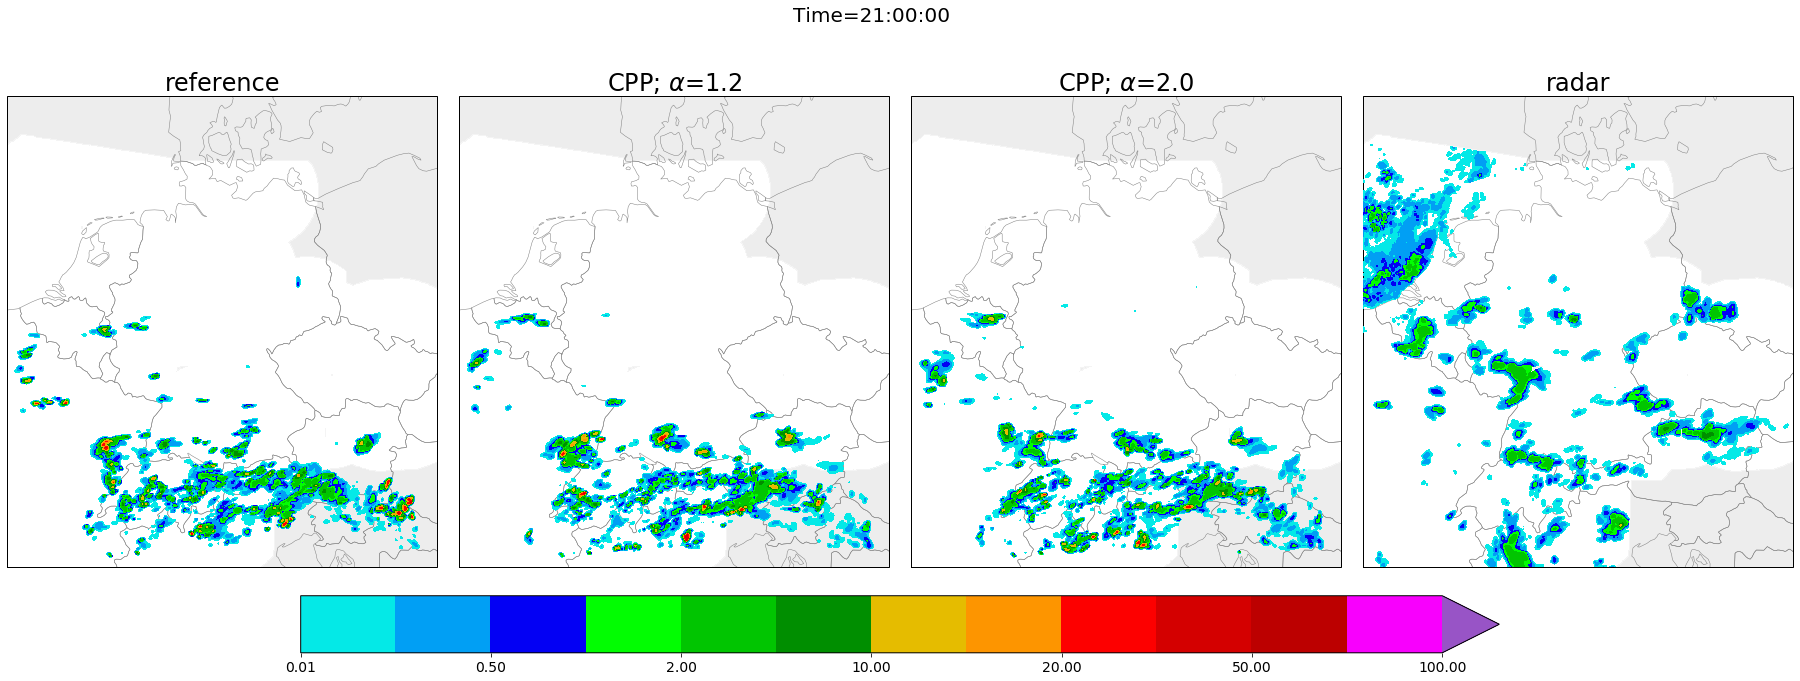

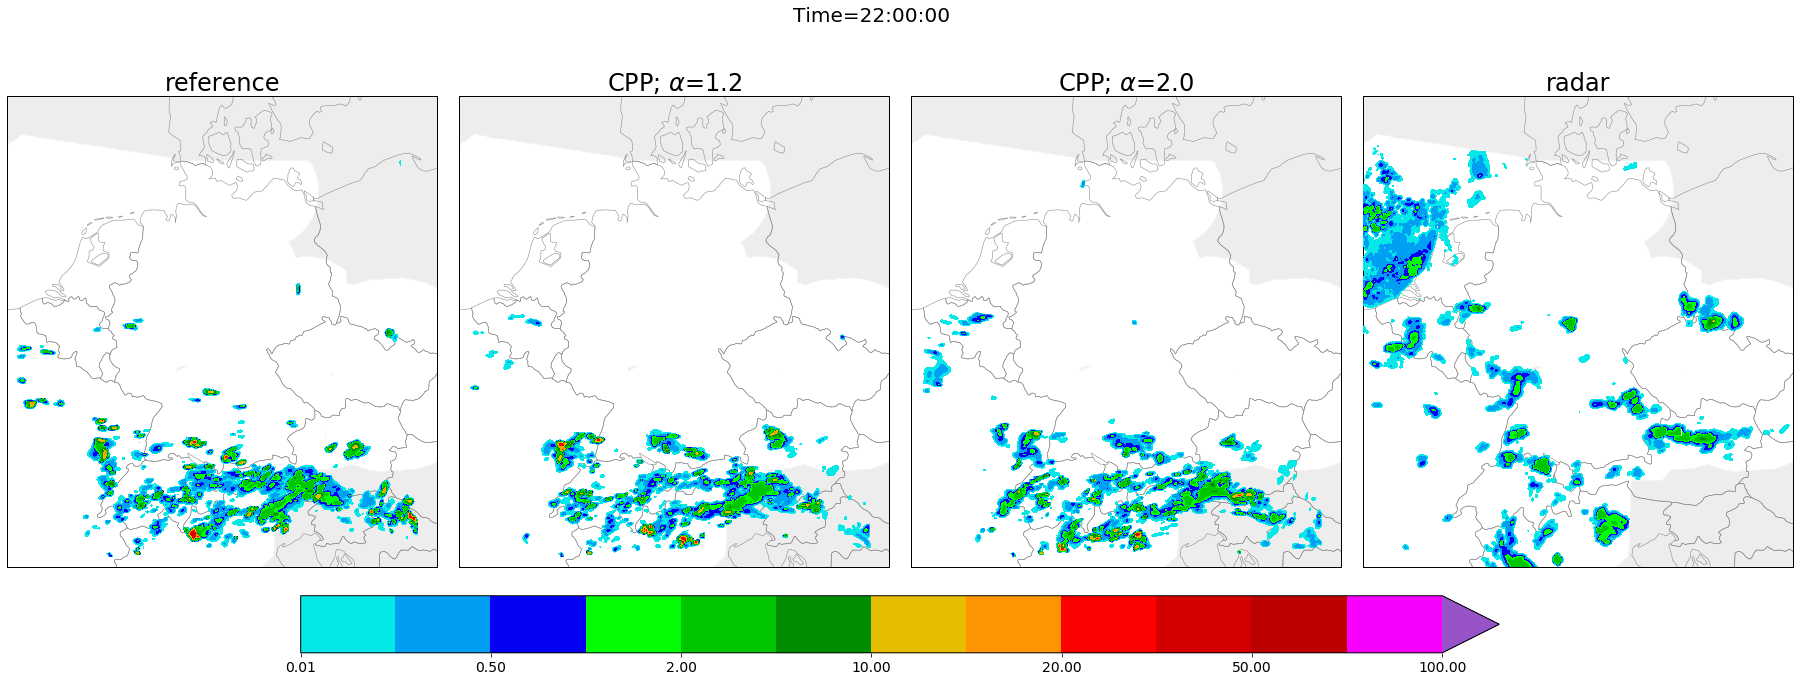

In [8]:
levs = np.array([0.01,0.1, 0.5, 1., 2., 6., 10., 15, 20., 30, 50,
                     70, 100]) 
for ti in [12,14,15,16, 17,18,19,20,21]:
    fig,axs = plot_prec_fields(prec_arrays, ti =ti, radar_mask=radar_mask, levels = levs,names = run_list)

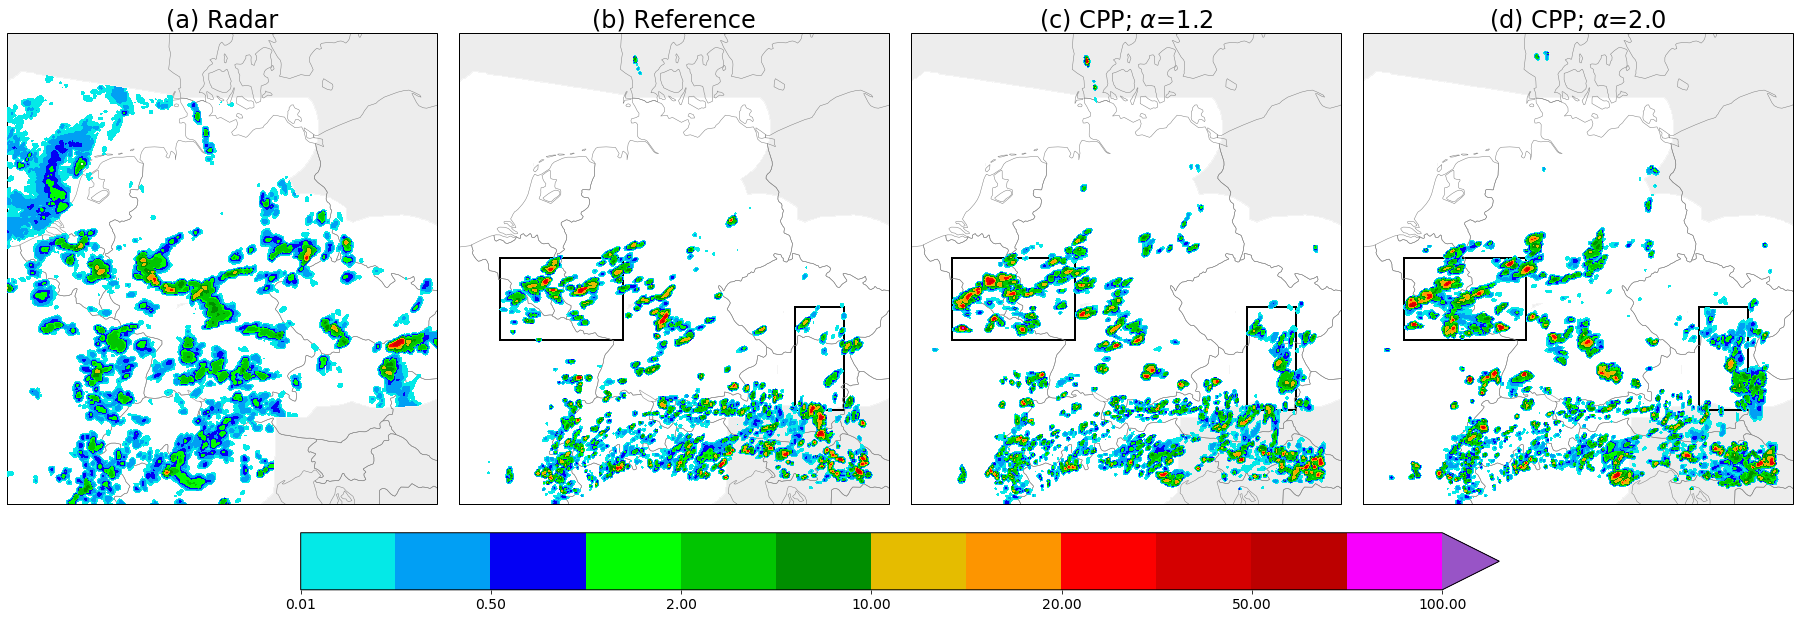

In [9]:
import matplotlib.patches as patches
levs = np.array([0.01,0.1, 0.5, 1., 2., 6., 10., 15, 20., 30, 50,
                     70, 100]) 
run_list = [ 'radar','reference',r'CPP; $\alpha$=1.2',r'CPP; $\alpha$=2.0', ]
for ti in [16,]:
    fig,axs = plot_prec_fields(prec_arrays, ti =ti, radar_mask=radar_mask, levels = levs,names = run_list)
    axs[1].set_title('(b) Reference')
    #axs[1].set_title('CPP', )
    axs[0].set_title('(a) Radar')
    axs[2].set_title(r'(c) CPP; $\alpha$=1.2')
    axs[3].set_title(r'(d) CPP; $\alpha$=2.0')
    
    # Create a Rectangle patch
    rect = patches.Rectangle((-4,-1),3,2,linewidth=2,edgecolor='k',facecolor='none')
    rect2 = patches.Rectangle((-4,-1),3,2,linewidth=2,edgecolor='k',facecolor='none')
    rect3 = patches.Rectangle((-4,-1),3,2,linewidth=2,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    axs[3].add_patch(rect)
    axs[1].add_patch(rect2)
    axs[2].add_patch(rect3)

    rect = patches.Rectangle((3.2,-2.7),1.2,2.5,linewidth=2,edgecolor='k',facecolor='none',)
    rect2 = patches.Rectangle((3.2,-2.7),1.2,2.5,linewidth=2,edgecolor='k',facecolor='none')
    rect3 = patches.Rectangle((3.2,-2.7),1.2,2.5,linewidth=2,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    axs[2].add_patch(rect)
    axs[1].add_patch(rect2)
    axs[3].add_patch(rect3)
    
    
   
    
    fig.suptitle('')
    #fig.savefig('../Figures/Paper/precip_example_org.pdf')

### FSS

In [15]:
from fss_functions import compute_fss
run_list.append('last_test') # needs to be added because compute_fss assumes radar as last and removes it
fss_df = compute_fss(selected_run_list=run_list, prec_arrays=prec_arrays.where(radar_mask))#.isel(ens=1))


INFO: Now computing fss
100%|██████████| 24/24 [00:16<00:00,  1.46it/s]


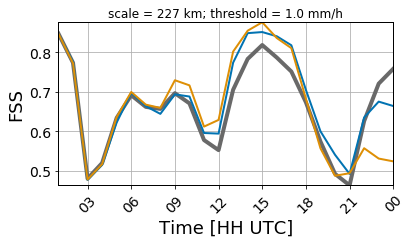

In [20]:
plt.figure(figsize=[6,3])
scale = 81
threshold=1
fss_sel = fss_df[(fss_df.scale==scale) & (fss_df.threshold==threshold)]

ref=  ['reference']
colors, linewidths = get_color_and_lw(ref, prec_arrays)
sns.lineplot(data=fss_sel, x = 'time', y = 'FSS', hue = 'run', 
             hue_order=ref, palette=colors,legend=False,
            size='run', size_order=ref, sizes = linewidths)

sns.lineplot(x = 'time', y = 'FSS',hue = 'run', 
             data = fss_sel[fss_sel['run'].isin(run_list[2:])], legend=False,
             palette=sns.color_palette("colorblind", 2),
            linewidth=2)


#leg = plt.legend(loc='upper left' , ncol=1, fontsize=14.)
#leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel(r'FSS')
plt.xlabel('Time [HH UTC]')
plt.grid()
plt.title('scale = %.0f km; threshold = %.1f mm/h'%(scale*2.8, threshold), fontsize='large')
plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
plt.gca().autoscale(tight=True)
figname = '../Figures/Paper/FSS_timeseries_alpha.pdf'
#plt.savefig(figname,bbox_inches='tight')

### S_SAL

In [21]:
from SAL_cosmo_utils import compute_SAL
def compute_SAL2(*args, **kwargs):
    S,_,_,_,_,_,_,_,_,_ = compute_SAL(*args,**kwargs)
    return(S)

kws = dict(user_threshold=None)

fcst = prec_arrays.to_array('run').where(radar_mask)
fcst = xr.where(fcst<0,0,fcst)# negative values are not possible
fcst = fcst.chunk({'time':1, 'run':1})

S_SAL = xr.apply_ufunc(compute_SAL2, prec_arrays['radar'].compute().chunk({'time':1}), fcst,
                     input_core_dims= [['rlat', 'rlon',], ['rlat', 'rlon']],
                     #output_core_dims=[['thresholds','scales']],
                     vectorize=True, 
                     dask = 'parallelized', output_dtypes=[float],# output_sizes = {'thresholds':3,'scales':4}, 
                      kwargs = kws).compute()
S_SAL.name='S-SAL'

In [22]:
S_df = S_SAL.to_dataframe().reset_index().rename(columns={'run':'run_type'})#.fillna(0)
print(S_df.columns)
#S_df = format_parameters(S_df)
S_df.describe()

Index(['time', 'run_type', 'rotated_pole', 'height_2m', 'height_10m',
       'height_toa', 'wbt_13c', 'S-SAL'],
      dtype='object')


height_2m  height_10m  height_toa    wbt_13c      S-SAL
count       96.0        96.0        96.0  96.000000  96.000000
mean         2.0        10.0     22000.0   1.300001  -0.907419
std          0.0         0.0         0.0   0.000001   0.588584
min          2.0        10.0     22000.0   1.300000  -1.656282
25%          2.0        10.0     22000.0   1.300000  -1.369922
50%          2.0        10.0     22000.0   1.300000  -1.087239
75%          2.0        10.0     22000.0   1.300000  -0.293205
max          2.0        10.0     22000.0   1.300000   0.000000

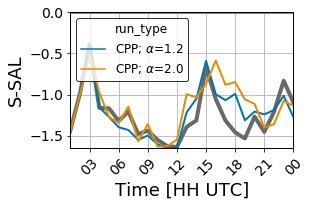

In [25]:
from matplotlib.dates import DateFormatter
#default_tau='deftau10min'
#sens_param='senstau'
#selected_run_list,line_kws, n_hues= get_run_selection(default_tau, sens_param, return_line_kws=True)

plt.figure(figsize=[4,2.5])
ref=  ['reference']
colors, linewidths = get_color_and_lw(ref, prec_arrays)
sns.lineplot(data=S_df, x = 'time', y = 'S-SAL', hue = 'run_type', 
             hue_order=ref, palette=colors, legend=False,
            size='run_type', size_order=ref, sizes = linewidths)

sns.lineplot(x = 'time', y = 'S-SAL',
             #style='kref',hue='$\\alpha_{cp}$',
             hue='run_type', 
             #hue ='$\\tau \\,[min]$',
             data = S_df[S_df['run_type'].isin(run_list[2:-1])], 
             palette=sns.color_palette("colorblind",2), #legend=False,
            linewidth=2)


leg = plt.legend(loc='upper left' , ncol=1, fontsize=12)
leg.get_frame().set_alpha(0.8)
#leg = plt.legend(bbox_to_anchor=(1.01, 1.15), loc=2, borderaxespad=0.,)
plt.xticks(rotation=45)
plt.ylabel(r'S-SAL')
plt.xlabel('Time [HH UTC]')
plt.grid()
plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
plt.hlines(0,min(S_df.time),max(S_df.time),colors='grey',linewidth=3)
#plt.title('threshold = %.1f mm/h'%(S_df.threshold_fcst[0]), fontsize='x-large')
plt.gca().autoscale(tight=True)
#plt.savefig('../Figures/Paper/SSAL_ts_alpha.pdf')

### Cloud sizes...

In [26]:
from rdf_functions import identify_clouds, identify_clouds_2   
def make_cloud_ds(prec_arrays, radar_mask, water_kws=dict(water=False), prec_thres=(1.0,)):
    egg = prec_arrays.where(radar_mask).compute().to_array(dim='run',name='precipitation').stack(time_run=['time', 'run'])
    labels = egg.groupby('time_run').apply(identify_clouds_2, args =prec_thres, return_var = 'labels', **water_kws)
    cld_size = egg.groupby('time_run').apply(identify_clouds_2, args =prec_thres,return_var='cld_size',**water_kws)
    cld_sum = egg.groupby('time_run').apply(identify_clouds_2, args =prec_thres,return_var='cld_sum', **water_kws)

    cloud_ds=xr.Dataset()
    cloud_ds['labels']= labels
    cloud_ds['cloud_size']= cld_size
    cloud_ds['cloud_sum']= cld_sum
    #cloud_ds = cloud_ds.unstack('time_run')
    cloud_ds = cloud_ds.unstack().rename_dims({'time_run_level_0':'time', 'time_run_level_1':'run'})
    cloud_ds = cloud_ds.rename_vars({'time_run_level_0':'time', 'time_run_level_1':'run'})
    cloud_ds['#_of_clouds'] = (cloud_ds.cloud_size>0).sum('cloud_number')
    cloud_ds['cloud_radius'] = np.sqrt(cloud_ds.cloud_size / np.pi) / 1000  # in km
    cloud_ds.attrs=water_kws
    cloud_ds.attrs['prec_thres'] = 1.0
    return cloud_ds

water_kws= dict(water=True, neighborhood = 3)
prec_thres=(5.0,)
cloud_ds_sep = make_cloud_ds(prec_arrays, radar_mask, water_kws=water_kws, prec_thres=prec_thres)

In [27]:
egg = cloud_ds_sep[['#_of_clouds']]
egg['median_cloud_radii'] = cloud_ds_sep.cloud_radius.median('cloud_number')
egg['mean_cloud_radii'] = cloud_ds_sep.cloud_radius.mean('cloud_number')

cloud_df = egg.to_dataframe().reset_index()
cloud_df = cloud_df.rename(columns={'run':'run_type'})
#cloud_df = format_parameters(cloud_df)
cloud_df.describe()

#_of_clouds  height_toa    wbt_13c  height_10m  height_2m  \
count    96.000000        96.0  96.000000        96.0       96.0   
mean    106.000000     22000.0   1.300001        10.0        2.0   
std      84.633327         0.0   0.000001         0.0        0.0   
min       3.000000     22000.0   1.300000        10.0        2.0   
25%      57.250000     22000.0   1.300000        10.0        2.0   
50%      78.500000     22000.0   1.300000        10.0        2.0   
75%     126.500000     22000.0   1.300000        10.0        2.0   
max     342.000000     22000.0   1.300000        10.0        2.0   

       median_cloud_radii  mean_cloud_radii  
count           96.000000         96.000000  
mean             2.243357          2.727213  
std              1.016027          0.757334  
min              0.000000          0.630611  
25%              1.579731          2.270165  
50%              2.234077          2.583280  
75%              2.789085          3.336201  
max              4.179575          4.325281

In [28]:
water_kws= dict(water=False, neighborhood = 3)
prec_thres=(5.0,)
cloud_ds_nonsep = make_cloud_ds(prec_arrays, radar_mask, water_kws=water_kws, prec_thres=prec_thres)

In [29]:
egg = cloud_ds_nonsep[['#_of_clouds']]
egg['median_cloud_radii'] = cloud_ds_nonsep.cloud_radius.median('cloud_number')
egg['mean_cloud_radii'] = cloud_ds_nonsep.cloud_radius.mean('cloud_number')

cloud_df_nonsep = egg.to_dataframe().reset_index()
cloud_df_nonsep = cloud_df_nonsep.rename(columns={'run':'run_type'})
#cloud_df_nonsep = format_parameters(cloud_df_nonsep)
cloud_df_nonsep.describe()

#_of_clouds  height_toa    wbt_13c  height_10m  height_2m  \
count    96.000000        96.0  96.000000        96.0       96.0   
mean     87.656250     22000.0   1.300001        10.0        2.0   
std      72.127056         0.0   0.000001         0.0        0.0   
min       2.000000     22000.0   1.300000        10.0        2.0   
25%      41.500000     22000.0   1.300000        10.0        2.0   
50%      65.500000     22000.0   1.300000        10.0        2.0   
75%     116.000000     22000.0   1.300000        10.0        2.0   
max     273.000000     22000.0   1.300000        10.0        2.0   

       median_cloud_radii  mean_cloud_radii  
count           96.000000         96.000000  
mean             3.136232          4.226613  
std              1.072163          1.324253  
min              1.579731          2.673654  
25%              2.234077          3.341756  
50%              2.736174          3.778659  
75%              3.532386          4.563931  
max              8.516590          8.516590

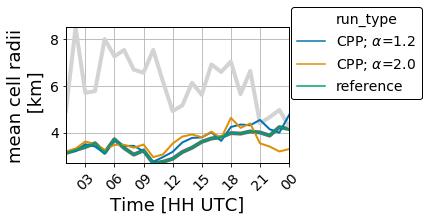

In [30]:
refrad_runs =  ['reference', 'radar']
colors, linewidths = get_color_and_lw(refrad_runs, prec_arrays)
plt.figure(figsize=[4,2.5])
sns.lineplot(x = 'time', y = 'mean_cloud_radii', hue='run_type', data = cloud_df_nonsep, 
             hue_order=refrad_runs, legend=False,
            palette=colors, size='run_type', sizes= linewidths, size_order =refrad_runs)

sns.lineplot(x = 'time', y = 'mean_cloud_radii',
             #hue='$\\alpha_{cp}$',style='$w_{max} [m s^{-1}]$',
             hue='run_type',
             #style='$w_{max} [m s^{-1}]$',
            #hue='$\\alpha_{cp}$', size ='fixedH',
             data = cloud_df_nonsep[cloud_df_nonsep['run_type'].isin(run_list[1:-1])], 
             palette=sns.color_palette("colorblind",3),
            linewidth=2,)


#leg = plt.legend(loc='lower left' , ncol=1, fontsize='11.5')
#leg.get_frame().set_alpha(0.8)
leg = plt.legend(bbox_to_anchor=(1.01, 1.15), loc=2, borderaxespad=0.,)
plt.xticks(rotation=45)
#lt.ylabel(r'mediancloud size')
plt.xlabel('Time [HH UTC]')
plt.ylabel('mean cell radii\n [km]')
plt.grid()
plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
plt.gca().autoscale(tight=True)


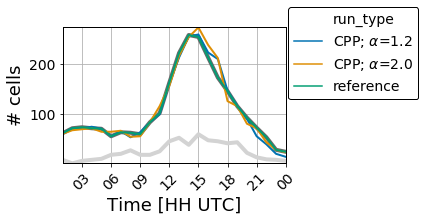

In [31]:

refrad_runs =  ['reference', 'radar']
colors, linewidths = get_color_and_lw(refrad_runs, prec_arrays)
plt.figure(figsize=[4,2.5])
sns.lineplot(x = 'time', y = '#_of_clouds', hue='run_type', data = cloud_df_nonsep,
             hue_order=refrad_runs, legend=False,
            palette=colors, size='run_type', sizes= linewidths, size_order =refrad_runs)

sns.lineplot(x = 'time', y = '#_of_clouds',
             #hue='$\\alpha_{cp}$',style='$w_{max} [m s^{-1}]$',
             hue='run_type',
             #style='$w_{max} [m s^{-1}]$',
            #hue='$\\alpha_{cp}$', size ='fixedH',
             data = cloud_df_nonsep[cloud_df_nonsep['run_type'].isin(run_list[1:-1])], 
             palette=sns.color_palette("colorblind",3), 
             #legend=False,
            linewidth=2,)


#leg = plt.legend(loc='lower left' , ncol=1, fontsize='small')
#leg.get_frame().set_alpha(0.8)
leg = plt.legend(bbox_to_anchor=(1.01, 1.15), loc=2, borderaxespad=0.,)
plt.xticks(rotation=45)
plt.ylabel(r'# cells')
plt.xlabel('Time [HH UTC]')
plt.grid()
plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
plt.gca().autoscale(tight=True)


 now separated cells

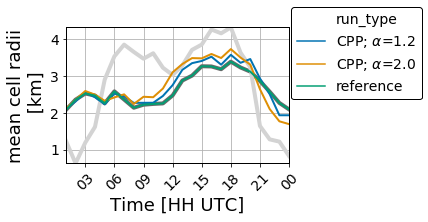

In [32]:
refrad_runs =  ['reference', 'radar']
colors, linewidths = get_color_and_lw(refrad_runs, prec_arrays)
plt.figure(figsize=[4,2.5])
sns.lineplot(x = 'time', y = 'mean_cloud_radii', hue='run_type', data = cloud_df, 
             hue_order=refrad_runs, legend=False,
            palette=colors, size='run_type', sizes= linewidths, size_order =refrad_runs)

sns.lineplot(x = 'time', y = 'mean_cloud_radii',
             #hue='$\\alpha_{cp}$',style='$w_{max} [m s^{-1}]$',
             hue='run_type',
             #style='$w_{max} [m s^{-1}]$',
            #hue='$\\alpha_{cp}$', size ='fixedH',
             data = cloud_df[cloud_df['run_type'].isin(run_list[1:-1])], 
             palette=sns.color_palette("colorblind",3),
            linewidth=2,)


#leg = plt.legend(loc='lower left' , ncol=1, fontsize='11.5')
#leg.get_frame().set_alpha(0.8)
leg = plt.legend(bbox_to_anchor=(1.01, 1.15), loc=2, borderaxespad=0.,)
plt.xticks(rotation=45)
#lt.ylabel(r'mediancloud size')
plt.xlabel('Time [HH UTC]')
plt.ylabel('mean cell radii\n [km]')
plt.grid()
plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
plt.gca().autoscale(tight=True)


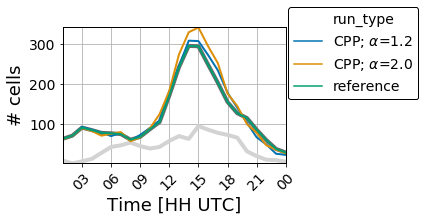

In [33]:

refrad_runs =  ['reference', 'radar']
colors, linewidths = get_color_and_lw(refrad_runs, prec_arrays)
plt.figure(figsize=[4,2.5])
sns.lineplot(x = 'time', y = '#_of_clouds', hue='run_type', data = cloud_df,
             hue_order=refrad_runs, legend=False,
            palette=colors, size='run_type', sizes= linewidths, size_order =refrad_runs)

sns.lineplot(x = 'time', y = '#_of_clouds',
             #hue='$\\alpha_{cp}$',style='$w_{max} [m s^{-1}]$',
             hue='run_type',
             #style='$w_{max} [m s^{-1}]$',
            #hue='$\\alpha_{cp}$', size ='fixedH',
             data = cloud_df[cloud_df['run_type'].isin(run_list[1:-1])], 
             palette=sns.color_palette("colorblind",3), 
             #legend=False,
            linewidth=2,)


#leg = plt.legend(loc='lower left' , ncol=1, fontsize='small')
#leg.get_frame().set_alpha(0.8)
leg = plt.legend(bbox_to_anchor=(1.01, 1.15), loc=2, borderaxespad=0.,)
plt.xticks(rotation=45)
plt.ylabel(r'# cells')
plt.xlabel('Time [HH UTC]')
plt.grid()
plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
plt.gca().autoscale(tight=True)


## Plots for gust front mask M

In [34]:
date =20160605
ds = get_data(run_name = 'cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0', load_hourly=True, date=date)


In [35]:
tv_grad = ds.DUMMY.isel(level=-1)
tv_avg = ds.DUMMY.isel(level=-2)
mul_factor = ds.DUMMY.isel(level=-5)
W0 = ds.DUMMY.isel(level=-4)
B = ds.DUMMY.isel(level=-3)

# just for sso-std data:
fname = '/project/meteo/scratch/M.Hirt/Cold_pool_perturbations/cosmo_runs/2016060500/cde_reference_turlen500_2016060500/OUTPUT/lfff00000000c.nc_1h.nc'
ds0  = xr.open_dataset(fname )

2016-06-05T15:00:00.000000000


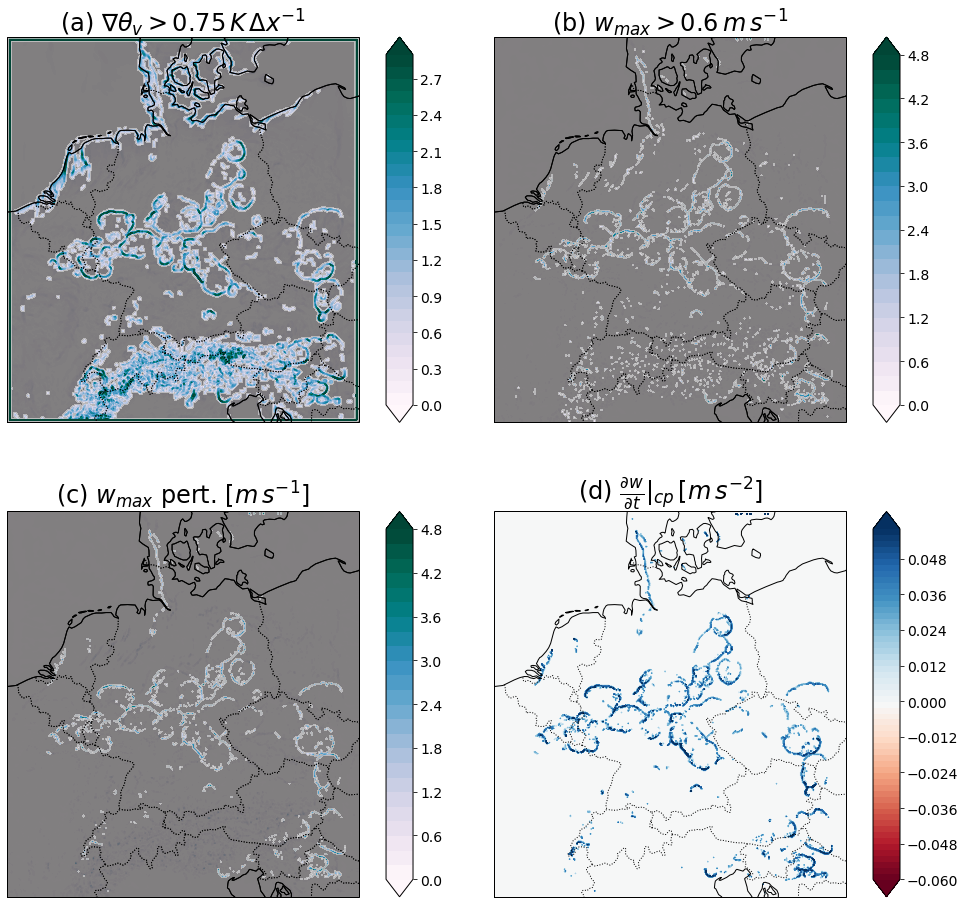

In [36]:
time = ds.time.isel(time=15)
print(time.values)

wmax_threshold=0.6

kws = dict(levels = np.arange (-1.,1.,.1), cmap='RdBu')
projection = ccrs.RotatedPole(
        pole_latitude=ds.rotated_pole.grid_north_pole_latitude,
        pole_longitude=ds.rotated_pole.grid_north_pole_longitude)
fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': projection},
                        sharex=True, sharey=True, figsize=[16,16])

axs = axs.ravel()

my_contour(tv_grad.sel(time=time)/2., figure=fig, levels = np.arange(0,3,0.1), axes = axs[0], cmap = 'PuBuGn')
from scipy.ndimage import uniform_filter
mask =(tv_grad.sel(time=time)).copy()>1.5
mask.values = uniform_filter(mask*1.,3)>0.000001
mask0 = mask.copy()
my_contour(mask,  figure=fig, levels=[0,.1,.21], axes = axs[0], cmap = 'Greys_r', alpha=.7, colorbar=False, extend=False)
axs[0].set_title(r'(a) $\nabla \theta_v > 0.75\,K\,\Delta x^{-1}$')

wmax = ds.W.isel(level1=slice(40,51)).max('level1').sel(time=time)
my_contour(wmax,  figure=fig, levels = np.arange(0,5,0.2), axes = axs[1],  cmap = 'PuBuGn')
my_contour((wmax>wmax_threshold).compute(), levels=[0,.1,.21], figure=fig, cmap = 'Greys_r',colorbar=False, axes=axs[1], filled=True, alpha=.7, extend=False)
axs[1].set_title(r'(b) $w_{max}>%.1f\,m\,s^{-1}$'%(wmax_threshold))

my_contour(wmax,  figure=fig, levels = np.arange(0,5,0.2), axes = axs[2], cmap = 'PuBuGn')
mask = (mask*(wmax>wmax_threshold)*(ds0.SSO_STDH.isel(time=0)<50)).compute()
my_contour(mask,  figure=fig, levels=[0,.1,.21], axes = axs[2], cmap = 'Greys_r', alpha=.7, colorbar=False, extend=False)
axs[2].set_title(r'(c) $w_{max}$ pert. $[m\,s^{-1}]$')



#my_contour(ds.WTENS_CP.isel(level1=40).sel(time=time),  figure=fig, levels = np.arange(-2,2,0.1)/10000, axes = axs[3], cmap = 'PuBuGn')
my_contour(ds.WTENS_CP.max('level1').sel(time=time),  levels = np.arange(-.6,.6,0.02)/10, cmap = 'RdBu', figure=fig,axes = axs[3],)
axs[3].set_title(r'(d) $ \left.\frac{\partial w }{\partial t}\right|_{cp} \, [m\,s^{-2}]$')



#fig.tight_layout()
plt.savefig('../Figures/Paper/Illustrate_horizontal_cp_mask.pdf')



## Comparison w vs w-target

In [37]:
dsets = dict()
date = 20160605
dsets['ref'] = get_data(run_name = 'reference', load_hourly=True, date=date)
dsets['cpp2.17'] = get_data(run_name = 'cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0', load_hourly=True, date = date)
dsets['cpp2.17a2'] = get_data(run_name = 'cpp2.17_tanh_a2.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0', load_hourly=True, date = date)
        
        


In [38]:
ds = dsets['cpp2.17']
tv_grad = ds.DUMMY.isel(level=-1)  # pot. temp. gradient
tv_avg = ds.DUMMY.isel(level=-2)   # pot. temp. 
mul_factor = ds.DUMMY.isel(level=-5) # multiplication factor with which to multiply w
W0 = ds.DUMMY.isel(level=-4)  # target vertical velocity (sqrt(BH))
B = ds.DUMMY.isel(level=-3) # estimate for buoyancy B

2016-06-05T15:00:00.000000000


Text(0.5, 1.0, '(b) CPP$\\alpha_{cp}1.2$; $\\alpha_{cp}\\sqrt{B\\cdot H}\\, [m s^{-1}]$')

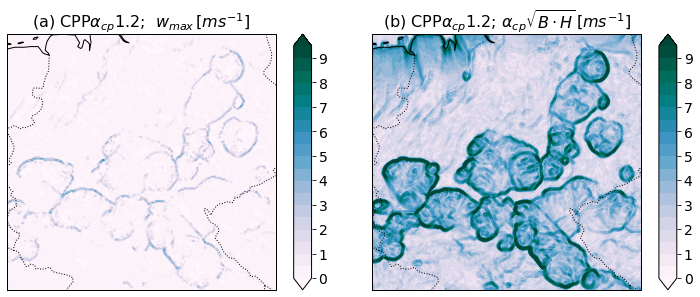

In [39]:
time = dsets['ref'].time.isel(time=15)
print(time.values)
kws = dict(levels = np.arange (-3.,3.,.2), cmap='RdBu')
projection = ccrs.RotatedPole(
        pole_latitude=dsets['cpp2.17'].rotated_pole.grid_north_pole_latitude,
        pole_longitude=dsets['cpp2.17'].rotated_pole.grid_north_pole_longitude)
fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': projection},
                        sharex=True, sharey=True, figsize=[12,6])

axs=axs.ravel()
my_contour(dsets['cpp2.17'].W.isel(level1=slice(38,50)).max('level1').sel(time=time).isel(rlat=slice(150,350),rlon=slice(100,310)),
           figure = fig, axes = axs[0],levels = np.arange (0,10.,.5), cmap='PuBuGn');
axs[0].set_title(r'(a) CPP$\alpha_{cp}1.2$;  $w_{max} \,[m s^{-1}]$', fontsize=16)
my_contour(W0.sel(time=time).isel(rlat=slice(150,350),rlon=slice(100,310))*1.2,figure = fig, axes = axs[1],levels = np.arange (0.,10.,.5), cmap='PuBuGn');
axs[1].set_title(r'(b) CPP$\alpha_{cp}1.2$; $\alpha_{cp}\sqrt{B\cdot H}\, [m s^{-1}]$', fontsize=16)
#fig.tight_layout()
#plt.savefig('../Figures/Paper/w_fields_examples_t15.svg')

#plt.savefig('../Figures/Paper/wmax_comparison_t15.pdf')

While the target amplitude is not fully reached by the model simulation at gust fronts, an increase of $\alpha$ does increase the gust front vertical velocities. This can be seen below, where an $\alpha$ of 2 is used and $w_{max}$ is indeed larger than in the figure above with $\alpha=1.2$.


2016-06-05T15:00:00.000000000


Text(0.5, 1.0, '(a) CPP2.17 $\\sqrt{B\\cdot H}$')

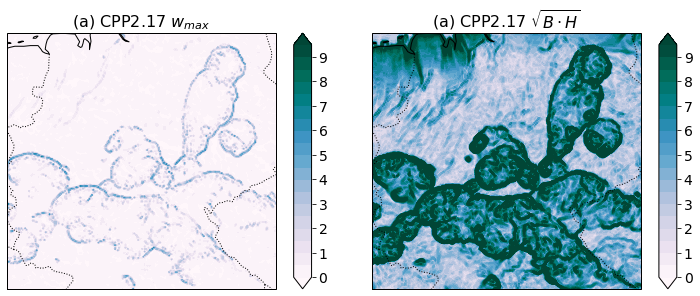

In [40]:
ds = dsets['cpp2.17a2']
tv_grad = ds.DUMMY.isel(level=-1)
tv_avg = ds.DUMMY.isel(level=-2)
mul_factor = ds.DUMMY.isel(level=-5)
W0 = ds.DUMMY.isel(level=-4)
B = ds.DUMMY.isel(level=-3)

time = dsets['ref'].time.isel(time=15)
print(time.values)
kws = dict(levels = np.arange (-3.,3.,.2), cmap='RdBu')
projection = ccrs.RotatedPole(
        pole_latitude=dsets['cpp2.17'].rotated_pole.grid_north_pole_latitude,
        pole_longitude=dsets['cpp2.17'].rotated_pole.grid_north_pole_longitude)
fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': projection},
                        sharex=True, sharey=True, figsize=[12,6])

axs=axs.ravel()
my_contour(dsets['cpp2.17a2'].W.isel(level1=slice(38,50)).max('level1').sel(time=time).isel(rlat=slice(150,350),rlon=slice(100,310)),
           figure = fig, axes = axs[0],levels = np.arange (0,10.,.5), cmap='PuBuGn');
axs[0].set_title(r'(a) CPP2.17 $w_{max}$', fontsize=16)
my_contour(W0.sel(time=time).isel(rlat=slice(150,350),rlon=slice(100,310))*2,figure = fig, axes = axs[1],levels = np.arange (0.,10.,.5), cmap='PuBuGn');
axs[1].set_title(r'(a) CPP2.17 $\sqrt{B\cdot H}$', fontsize=16)



2016-06-05T15:00:00.000000000


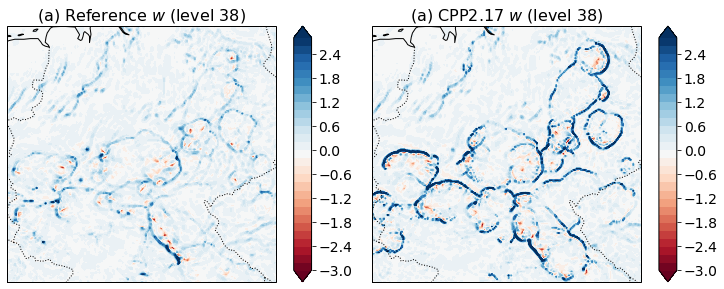

In [41]:
%matplotlib inline
time = dsets['ref'].time.isel(time=15)
print(time.values)
kws = dict(levels = np.arange (-3,3,.2), cmap='RdBu')
projection = ccrs.RotatedPole(
        pole_latitude=dsets['cpp2.17'].rotated_pole.grid_north_pole_latitude,
        pole_longitude=dsets['cpp2.17'].rotated_pole.grid_north_pole_longitude)
fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': projection},
                        sharex=True, sharey=True, figsize=[12,6])

axs=axs.ravel()
my_contour(dsets['ref'].W.sel(time=time, level1=38).isel(rlat=slice(150,350),rlon=slice(100,310)),figure = fig, axes = axs[0], **kws);
axs[0].set_title(r'(a) Reference $w$ (level 38)', fontsize=16)
my_contour(dsets['cpp2.17'].W.sel(time=time, level1=38).isel(rlat=slice(150,350),rlon=slice(100,310)),figure = fig, axes = axs[1], **kws);
axs[1].set_title(r'(a) CPP2.17 $w$ (level 38)', fontsize=16)

#plt.savefig('../Figures/Paper/w_fields_examples_t15.svg')
plt.savefig('../Figures/Paper/w_fields_examples_t15.pdf')

2016-06-05T16:00:00.000000000


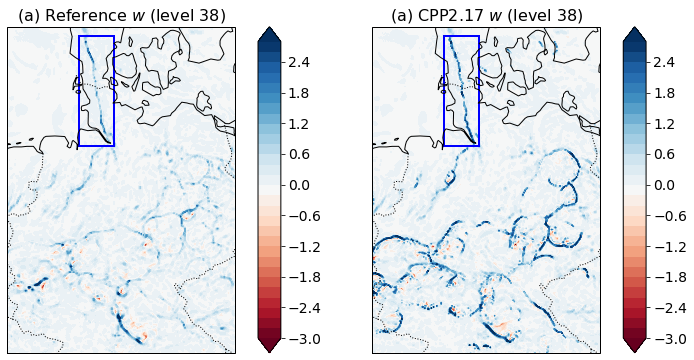

In [42]:

    
%matplotlib inline
time = dsets['ref'].time.isel(time=16)
print(time.values)
kws = dict(levels = np.arange (-3,3,.2), cmap='RdBu')
projection = ccrs.RotatedPole(
        pole_latitude=dsets['cpp2.17'].rotated_pole.grid_north_pole_latitude,
        pole_longitude=dsets['cpp2.17'].rotated_pole.grid_north_pole_longitude)
fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': projection},
                        sharex=True, sharey=True, figsize=[12,6])

axs=axs.ravel()
my_contour(dsets['ref'].W.sel(time=time, level1=38).isel(rlat=slice(150,450),rlon=slice(100,310)),figure = fig, axes = axs[0], **kws);
axs[0].set_title(r'(a) Reference $w$ (level 38)', fontsize=16)
my_contour(dsets['cpp2.17'].W.sel(time=time, level1=38).isel(rlat=slice(150,450),rlon=slice(100,310)),figure = fig, axes = axs[1], **kws);
axs[1].set_title(r'(a) CPP2.17 $w$ (level 38)', fontsize=16)


rect = patches.Rectangle((-0.85,3.5),.8,2.5,linewidth=2,edgecolor='b',facecolor='none')
rect2 = patches.Rectangle((-0.85,3.5),.8,2.5,linewidth=2,edgecolor='b',facecolor='none')
# Add the patch to the Axes
axs[0].add_patch(rect)
axs[1].add_patch(rect2)
#plt.savefig('../Figures/Paper/w_fields_examples_t15.svg')
#plt.savefig('../Figures/Paper/w_fields_examples_t15.pdf')

In [43]:
date =20160605
ds = get_data(run_name = 'cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0', load_hourly=True, date=date)


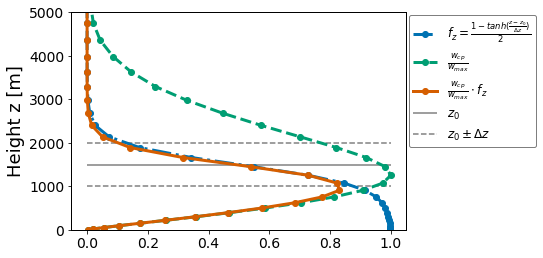

In [44]:
#z = np.arange(0,5000,100)
z = ds.vcoord
z0 =1500
dz=500
y = (-np.tanh((z-z0)/dz)+1)/2
plt.plot(y, z, '-o', label=r'$f_z=\frac{1-tanh(\frac{z-z_0}{\Delta z})}{2}$', lw=3, linestyle='-.')
plt.hlines(z0, 0,1,linestyle='-', color='grey', label=r'$z_0$')
plt.hlines(z0-dz, 0,1,linestyle='--', color='grey',)
plt.hlines(z0+dz, 0,1,linestyle='--', color='grey',label=r'$z_0\pm \Delta z$')


#ds = dsets['cpp2.17']
egg= ds.W.where(ds.WTENS_CP.isel(level1=45)>0).mean(['rlat','rlon']).isel(time=15)
egg=egg/egg.max()
egg['vcoord'] = ds.vcoord
egg.plot(y='vcoord',marker='o', label=r'$\frac{w_{cp}}{w_{max}}$', lw=3, linestyle='--')
(egg*y).plot(y='vcoord', marker='o',linestyle='-', label=r'$\frac{w_{cp}}{w_{max}}\cdot f_z$', lw=3)

egg= ds.WTENS_CP.where(ds.WTENS_CP.isel(level1=45)>0).mean(['rlat','rlon']).isel(time=16)
egg['vcoord'] = ds.vcoord
#(egg*10).plot(y='vcoord',marker='*', label='Wtens_CP*10')


plt.ylim([0,5000])
plt.ylabel('Height z [m]')
#y.differentiate('level1').plot(y='vcoord', marker='*', label='d/dz')
#leg = plt.legend(loc='upper right' , ncol=1, fontsize='medium')
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2,fontsize='large' )
leg.get_frame().set_alpha(0.5)
plt.title('')
plt.savefig('../Figures/Paper/tanh_vertical profile.pdf',bbox_inches='tight')

## Theta -v: shows example strengths of cols pools
(A more quantitative analysis on cold pools is in another notebook)

In [47]:
dsets = dict()
date = 20160605
dsets['ref'] = get_data(run_name = 'reference', load_hourly=True, date=date)
dsets['cpp2.17'] = get_data(run_name = 'cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0', load_hourly=True, date = date)
        

2016-06-05T14:00:00.000000000


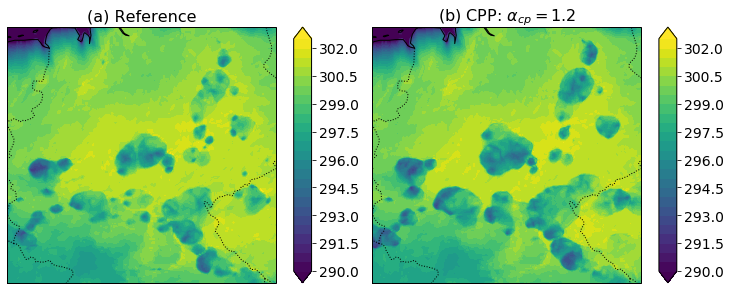

In [48]:
%matplotlib inline
time = dsets['ref'].time.isel(time=14)
print(time.values)
kws = dict(levels = np.arange (290,303,.5), cmap='viridis')
projection = ccrs.RotatedPole(
        pole_latitude=dsets['cpp2.17'].rotated_pole.grid_north_pole_latitude,
        pole_longitude=dsets['cpp2.17'].rotated_pole.grid_north_pole_longitude)
fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': projection},
                        sharex=True, sharey=True, figsize=[12,8])

axs=axs.ravel()
my_contour(dsets['ref'].theta_v_sfc.sel(time=time).isel(rlat=slice(150,350),rlon=slice(100,310)),figure = fig, axes = axs[0], **kws);
axs[0].set_title(r'(a) Reference', fontsize=16)
my_contour(dsets['cpp2.17'].theta_v_sfc.sel(time=time).isel(rlat=slice(150,350),rlon=slice(100,310)),figure = fig, axes = axs[1],**kws);
axs[1].set_title(r'(b) CPP: $ \alpha_{cp}=1.2$', fontsize=16)

#my_contour(dsets['cpp2.11_t30min'].theta_v_sfc.sel(time=time),figure = fig, axes = axs[2],**kws);
#axs[2].set_title(r'(c) CPP:  $\tau_{cp}=30\,min$; $\alpha_{cp}=3$', fontsize=16)

plt.savefig('../Figures/Paper/thetavsfc_fields_examples_t14.pdf')

## CAPE

In [49]:
#from misc_functions import get_data
dsets = dict()
date = 20160605
dsets['ref'] = get_data(run_name = 'reference', load_hourly=False, date=date)
dsets['cpp2.17_a1.0'] = get_data(run_name = 'cpp2.17_tanh_a1.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0', load_hourly=False, date = date)
dsets['cpp2.17_a1.2'] = get_data(run_name = 'cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0', load_hourly=False, date = date)
dsets['cpp2.17_a1.5'] = get_data(run_name = 'cpp2.17_tanh_a1.5_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0', load_hourly=False, date = date)
#dsets['cpp+PSP2'] = get_data(run_name = 'PSP2_cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0', load_hourly=False, date = date)   

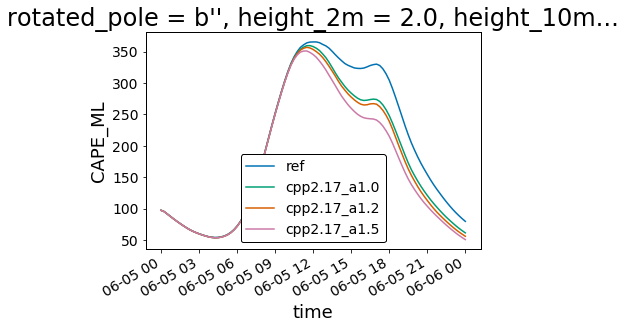

In [51]:
for run in['ref', 'cpp2.17_a1.0', 'cpp2.17_a1.2', 'cpp2.17_a1.5']:
    dsets[run].CAPE_ML.mean( ['rlat','rlon']).plot(label=run)
plt.legend()


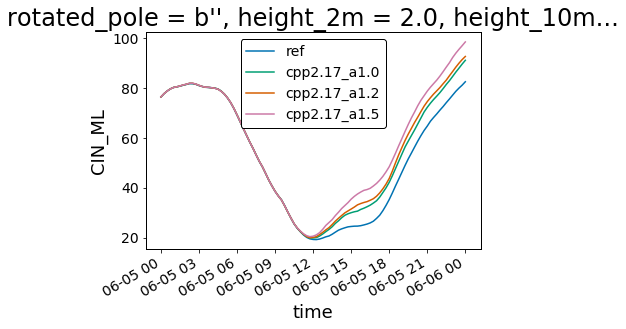

In [52]:
for run in['ref', 'cpp2.17_a1.0', 'cpp2.17_a1.2', 'cpp2.17_a1.5']:
    egg = dsets[run].CIN_ML
    egg.where(egg>0).compute().mean( ['rlat','rlon']).plot(label=run)
plt.legend()

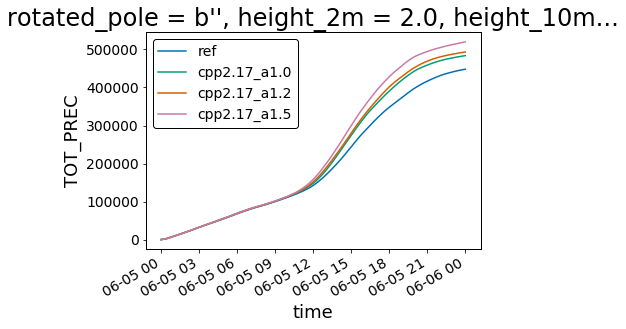

In [53]:
for run in['ref', 'cpp2.17_a1.0', 'cpp2.17_a1.2', 'cpp2.17_a1.5']:
    egg = dsets[run].TOT_PREC
    egg.where(egg>0).compute().sum( ['rlat','rlon']).plot(label=run)
plt.legend()

# Whole period

In [4]:
selected_run_list =  ['reference',
#                      '2moment_reference',
                      #'cpp2.11_a0.3_wmax0.5_kref38_theta1.5_sso50.0_tau1800.0',
                      #'cpp2.11_a0.3_wmax0.5_kref38_theta1.5_sso50.0_tau3600.0',
                      #'cpp2.11_a0.2_wmax0.5_kref38_theta1.5_sso50.0_tau600.0',
                      #'cpp2.11_a0.3_wmax0.5_kref36_theta1.5_sso50.0_tau1800.0',
                      #'cpp2.11_a0.2_wmax0.5_kref38_theta1.5_sso50.0_tau1800.0',
                      #'cpp2.11_a0.15_wmax0.5_kref38_theta1.5_sso50.0_tau600.0',
                      #'cpp2.17_tanh_a1.0_wmax0.6_kref38_theta1.5_sso50.0_tau150.0_dh500.0_h01000.0',
                      #'cpp2.17_tanh_a1.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                      'cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                      #'cpp2.17_tanh_a1.5_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                      'cpp2.17_tanh_a2.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                      #'cpp2.17_tanh_a3.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                      #'cpp2.17_tanh_a2.0_wmax0.6_kref38_theta1.5_sso50.0_tau200.0_dh500.0_h01500.0',
                      'cpp2.17_tanh_a3.0_wmax0.6_kref38_theta1.5_sso50.0_tau300.0_dh500.0_h01500.0',
                      #'PSP2a0.8_cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                      #'PSP2a1_cpp2.17_tanh_a1.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                      #'PSP2a0.8_cpp2.17_tanh_a0.8_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                      #'PSP2a1.5_cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                      #'PSPa4_cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0',
                      #'PSP2a1_cpp2.11_a0.2_wmax0.5_kref38_theta1.5_sso50.0_tau600.0',
                      #'PSP2',
    'radar']
ds_list=[]
rmask_list= []
for date in  [ '20160529','20160530','20160531', '20160601', '20160602', '20160603', '20160604', #'20160527', '20160528', , '20160608', '20160609'
            '20160605','20160606', '20160607']: 
    logging.info(date)
    prec_arrays = get_prec_data(run_names = selected_run_list, date=date)
    prec_arrays['start_date'] = prec_arrays.time.isel(time=0).time -np.timedelta64(1,'h') # data starts at 1, not 00 --> subtract 1 hour for start_date
    prec_arrays['leadtime'] = (prec_arrays.time - prec_arrays.start_date)/ np.timedelta64(1,'h')
    prec_arrays = prec_arrays.set_coords(['leadtime', 'start_date'])
    prec_arrays = prec_arrays.swap_dims({'time':'leadtime'})
    del prec_arrays['time']
    #prec_arrays['hour'] = prec_arrays.time
    
    ds_list.append(prec_arrays)
    radar_mask = get_radar_mask(date=date, use_time_dependent=False) 
    rmask_list.append(radar_mask)
prec_arrays = xr.concat(ds_list, dim ='start_date')
radar_mask = xr.concat(rmask_list, dim ='time')
radar_mask = radar_mask.rename({'time':'start_date'})


INFO: 20160529
100%|██████████| 5/5 [00:08<00:00,  1.60s/it]
INFO: 20160530
100%|██████████| 5/5 [00:08<00:00,  1.61s/it]
INFO: 20160531
100%|██████████| 5/5 [00:09<00:00,  1.64s/it]
INFO: 20160601
100%|██████████| 5/5 [00:09<00:00,  1.64s/it]
INFO: 20160602
100%|██████████| 5/5 [00:09<00:00,  1.64s/it]
INFO: 20160603
100%|██████████| 5/5 [00:09<00:00,  1.63s/it]
INFO: 20160604
100%|██████████| 5/5 [00:09<00:00,  1.65s/it]
INFO: 20160605
100%|██████████| 5/5 [00:09<00:00,  1.64s/it]
INFO: 20160606
100%|██████████| 5/5 [00:08<00:00,  1.59s/it]
INFO: 20160607
 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

KeyboardInterrupt: 

In [ ]:
prec_arrays = prec_arrays.rename_vars({'cpp2.17_tanh_a1.2_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0': 'CPP2.17-a1.2'})
prec_arrays = prec_arrays.rename_vars({'cpp2.17_tanh_a2.0_wmax0.6_kref38_theta1.5_sso50.0_tau120.0_dh500.0_h01500.0': 'CPP2.17-a2'})
prec_arrays = prec_arrays.rename_vars({'cpp2.17_tanh_a3.0_wmax0.6_kref38_theta1.5_sso50.0_tau300.0_dh500.0_h01500.0': 'CPP2.17-a3-t300'})


In [ ]:
prec_arrays

In [ ]:
selected_run_list =  ['reference', 'radar',
                      'CPP2.17-a1.2',
                      'CPP2.17-a2',
                      'CPP2.17-a3-t300',

                     ]



In [ ]:
egg=prec_arrays.where(radar_mask).mean(['rlon','rlat'])
egg = egg.where(egg>0)
df = egg.to_dataframe()


In [ ]:
df = df.reset_index()
#df['hour'] = df.time.dt.hour
#df['date'] = df.time.dt.date
df = df.melt(id_vars=['leadtime','start_date', 'height_2m', 'height_10m', 'height_toa', 'wbt_13c'], var_name = 'run', value_name='precipitation')


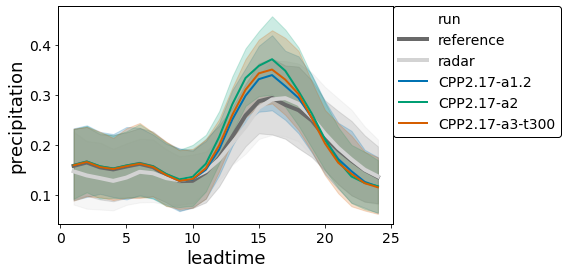

In [60]:
from misc_functions import get_color_and_lw
colors, lws = get_color_and_lw(selected_run_list, prec_arrays,)
kws = dict(x = 'leadtime', y = 'precipitation', hue='run', palette=colors, size='run', sizes=lws, 
           hue_order=selected_run_list, size_order=selected_run_list)
sns.lineplot(data = df[df['run'].isin(selected_run_list)], **kws)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )

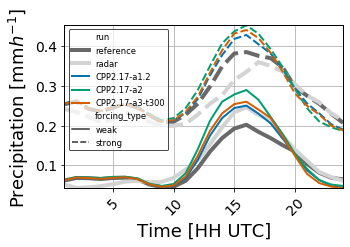

In [61]:
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>='2016-06-03', 'forcing_type']='weak'


%matplotlib inline
plt.figure(figsize=[5,3])
colors, lws = get_color_and_lw(selected_run_list)
#lws = [3, 3, 3, 3, 3]
kws = dict(x = 'leadtime', y = 'precipitation', hue='run', palette=colors, size='run', style='forcing_type',
           hue_order=selected_run_list, size_order=selected_run_list,
           style_order=['weak','strong'], sizes=lws, ci=None, legend='brief')
sns.lineplot(data = df[df['run'].isin(selected_run_list)], **kws)
leg = plt.legend(loc='upper left' , ncol=1, fontsize='small')
leg.get_frame().set_alpha(0.7)
#leg = plt.legend(bbox_to_anchor=(1.01, 1.15), loc=2, borderaxespad=0.,)
plt.xticks(rotation=45)
plt.ylabel(r'Precipitation [mm$h^{-1}$]')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))

plt.gca().autoscale(tight=True)
#plt.savefig('../Figures/Paper/whole_period_prec_ts.pdf',bbox_inches='tight')

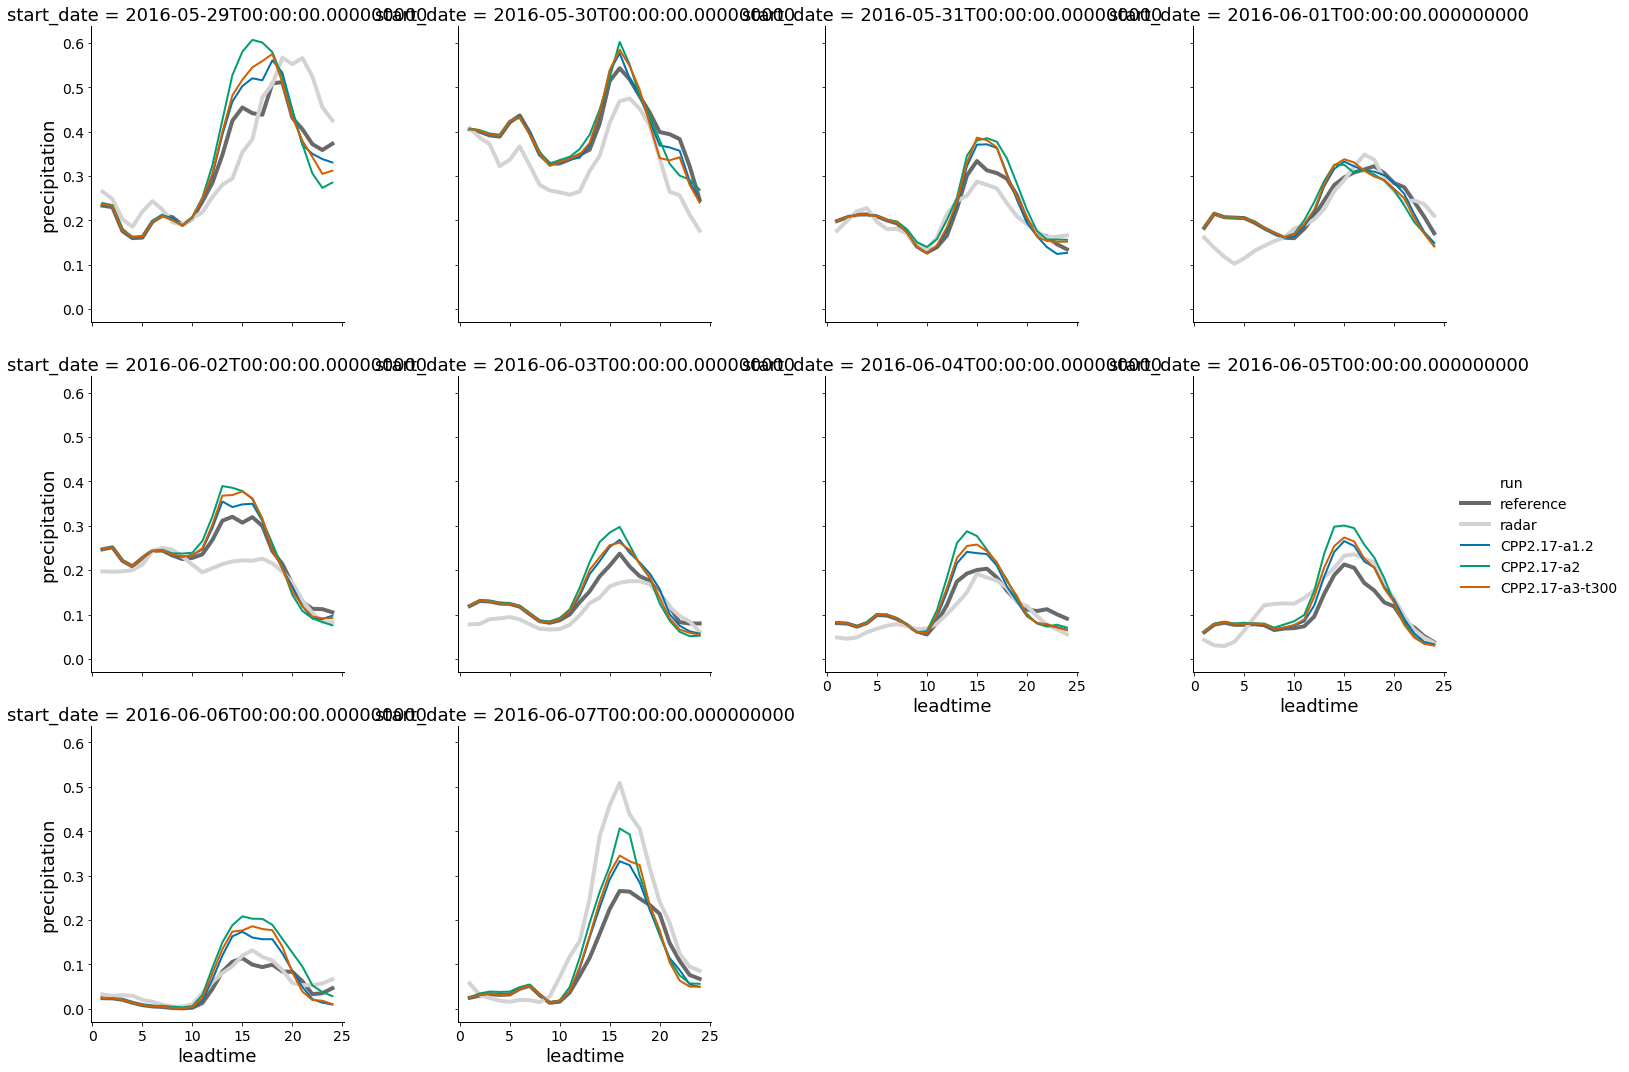

In [62]:
%matplotlib inline
colors, lws = get_color_and_lw(selected_run_list, prec_arrays)
kws = dict(x = 'leadtime', y = 'precipitation', hue='run', col='start_date', col_wrap=4, kind='line', palette=colors, size='run', sizes=lws, 
          hue_order=selected_run_list, size_order=selected_run_list)
sns.relplot(data = df[df['run'].isin(selected_run_list)], **kws)

### FSS

In [63]:
def compute_fss(selected_run_list = ['refrestart', 'radar'], date='20160606', thresholds=[0.1, 0.5, 1.], scales=[ 21, 41, 61, 81], prec_arrays = None): 
    """
    compute_fss loads in precipitation data (if not given) and then computes the fss. 
    
    Parameters
    ----------
    selected_run_list : list, optional
        has to indclude radar data, otherwise fss cannot be computed, by default ['refrestart', 'radar']
    date : str, optional
        [description], by default '20160606'
    thresholds : list, optional
        [description], by default [0.1, 0.5, 1.]
    scales : list, optional
        [description], by default [ 21, 41, 61, 81]
    
    Returns
    -------
    [pd.dataset]
        [Dataset contains FSS values for all thresholds, scales, times and runs]
    """
    # TODO: include ensemble dim
    from misc_functions import get_prec_data, get_radar_mask
    if not prec_arrays: 
        logging.info('Now reading in data.')
        prec_arrays = get_prec_data(run_names = selected_run_list,date=date)
        radar_mask = get_radar_mask(date=date, use_time_dependent=False)  
        prec_arrays = prec_arrays.where(radar_mask)
    list_t = []
    logging.info('Now computing fss')
    for t in tqdm(prec_arrays.time): 
        prec_sel = prec_arrays.sel(time=t)
        obs = prec_sel.radar.values
        list_run = []
        for run_name in selected_run_list:
            fcst = prec_sel[run_name].values
            egg = fss_frame(fcst, obs, windows=scales, levels = thresholds)[2]
            egg = egg.unstack().reset_index()
            egg = egg.rename(columns={'level_0':'scale', 'level_1': 'threshold', 0:'FSS'})
            egg['time']=t.values
            egg['run'] = run_name
            list_run.append(egg)
        list_t.append(pd.concat(list_run))
    fss_df = pd.concat(list_t)
    fss_df['FSS'] = fss_df.FSS.where(fss_df.FSS>0)
    return fss_df


In [64]:
from fss_functions import fss_frame
fss_df = compute_fss(selected_run_list=selected_run_list,prec_arrays=prec_arrays.where(radar_mask).stack(time = ['start_date', 'leadtime']))
fss_df[['start_time', 'leadtime']] = pd.DataFrame(fss_df['time'].tolist(), index=fss_df.index)
del fss_df['time']

INFO: Now computing fss
100%|██████████| 240/240 [04:00<00:00,  1.01s/it]


In [65]:
# replace nan with 0
fss_df = fss_df.replace(np.nan, 0)

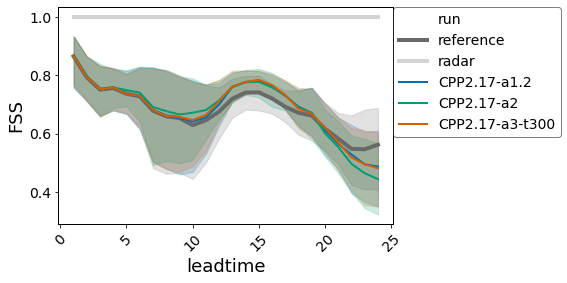

In [66]:
from misc_functions import get_color_and_lw
colors, lws = get_color_and_lw(selected_run_list, prec_arrays)
sns.lineplot(data = fss_df[(fss_df.threshold == 1)  & (fss_df.scale == 81)], x = 'leadtime', y = 'FSS', hue = 'run',  
             hue_order=selected_run_list, size_order=selected_run_list,
             palette=colors, legend='brief', size= 'run', sizes=lws,)
plt.xticks(rotation=45)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
leg.get_frame().set_alpha(0.5)

In [67]:
fss_df.run.unique()

array(['reference', 'radar', 'CPP2.17-a1.2', 'CPP2.17-a2',
       'CPP2.17-a3-t300'], dtype=object)

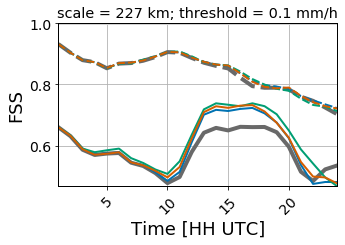

In [68]:
fss_df['forcing_type']=None
fss_df.loc[fss_df.start_time<'2016-06-03', 'forcing_type']='strong'
fss_df.loc[fss_df.start_time>'2016-06-03', 'forcing_type']='weak'

colors, lws = get_color_and_lw(selected_run_list, prec_arrays)
#lws = [3, 3, 3, 3, 3]

scale = 81
threshold=0.1
fss_sel = fss_df[(fss_df.scale==scale) & (fss_df.threshold==threshold) & ( fss_df.run.isin(selected_run_list))]



plt.figure(figsize=[5,3])
sns.lineplot(data = fss_sel, x = 'leadtime', y = 'FSS', hue = 'run',   
             hue_order=selected_run_list, size_order=selected_run_list,
             palette=colors, legend=False, size= 'run', sizes=lws, style='forcing_type', 
             style_order=['weak','strong'],ci=None )
plt.xticks(rotation=45)
#leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg.get_frame().set_alpha(0.5)

#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
#leg.get_frame().set_alpha(0.8)
#leg = plt.legend(bbox_to_anchor=(1.01, 1.15), loc=2, borderaxespad=0.,)
plt.xticks(rotation=45)
plt.ylabel(r'FSS')
plt.xlabel('Time [HH UTC]')
plt.grid()
plt.title('scale = %.0f km; threshold = %.1f mm/h'%(scale*2.8, threshold), fontsize='x-large')
plt.gca().autoscale(tight=True)
#plt.savefig('../Figures/Paper/whole_period_fss_ts.pdf',bbox_inches='tight')

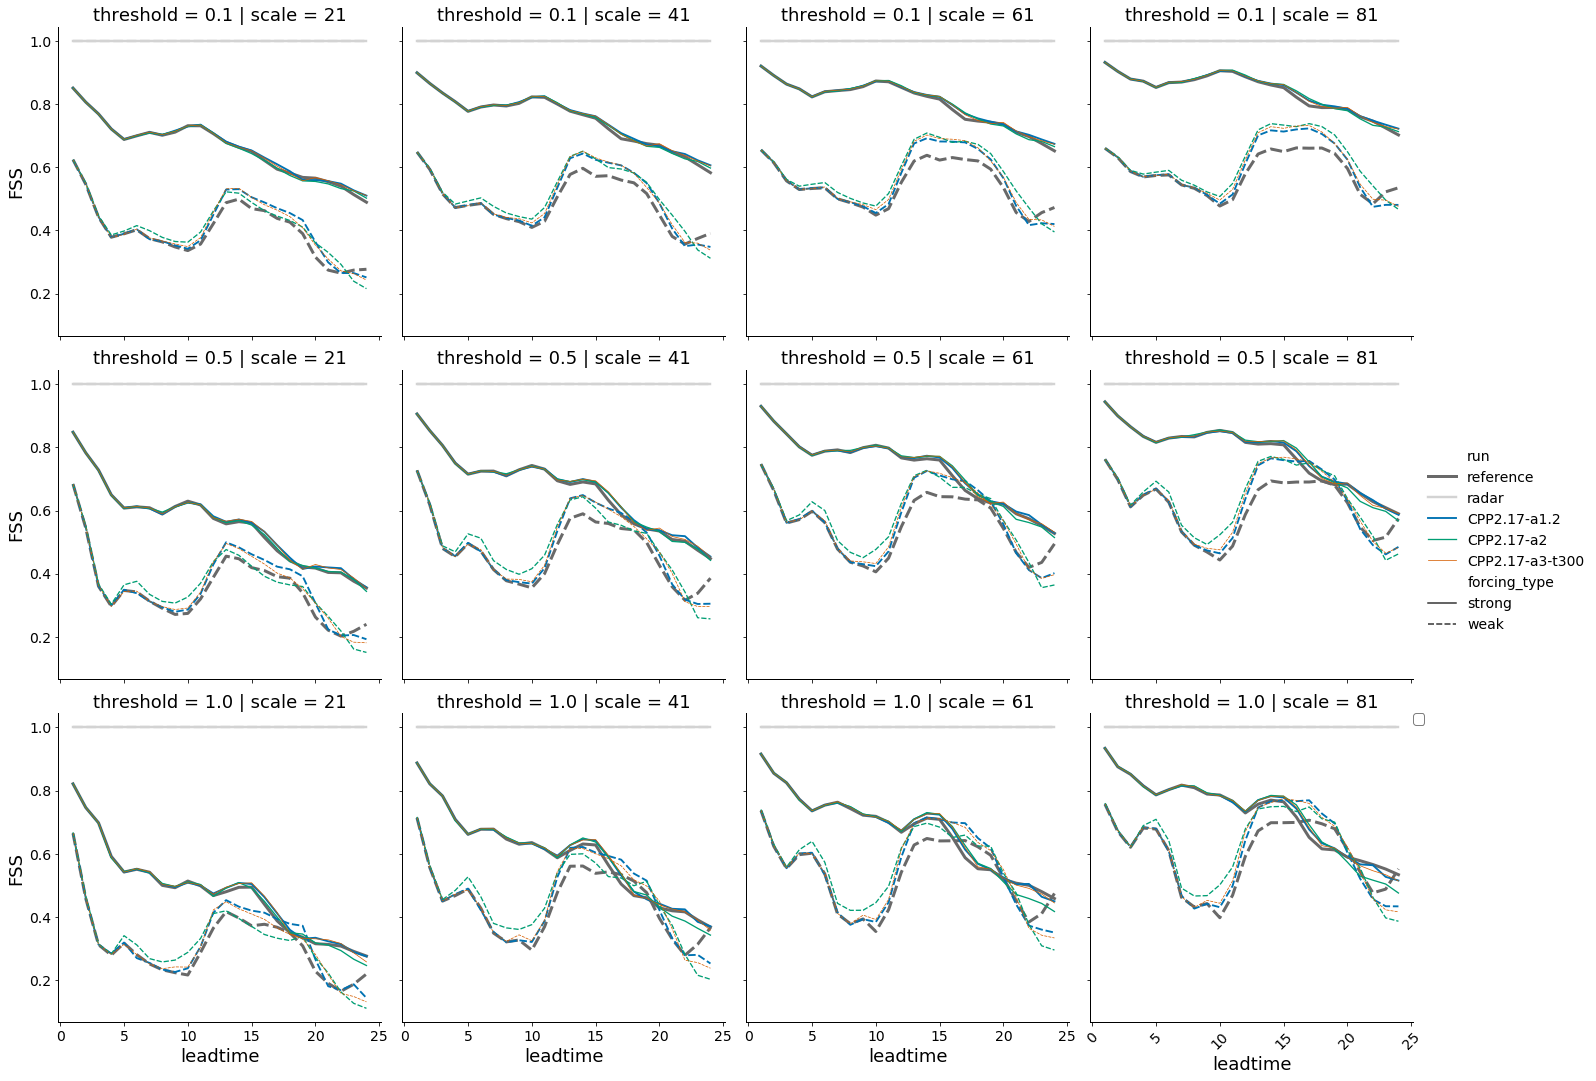

In [69]:
fss_df['forcing_type']=None
fss_df.loc[fss_df.start_time<'2016-06-03', 'forcing_type']='strong'
fss_df.loc[fss_df.start_time>'2016-06-03', 'forcing_type']='weak'


sns.relplot(data = fss_df[fss_df.run.isin(selected_run_list)], x = 'leadtime', y = 'FSS', hue = 'run',   
            hue_order=selected_run_list, kind='line',
             palette=colors, legend='brief', size= 'run', style='forcing_type', ci=None, 
           col ='scale', row='threshold')
plt.xticks(rotation=45)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
leg.get_frame().set_alpha(0.5)

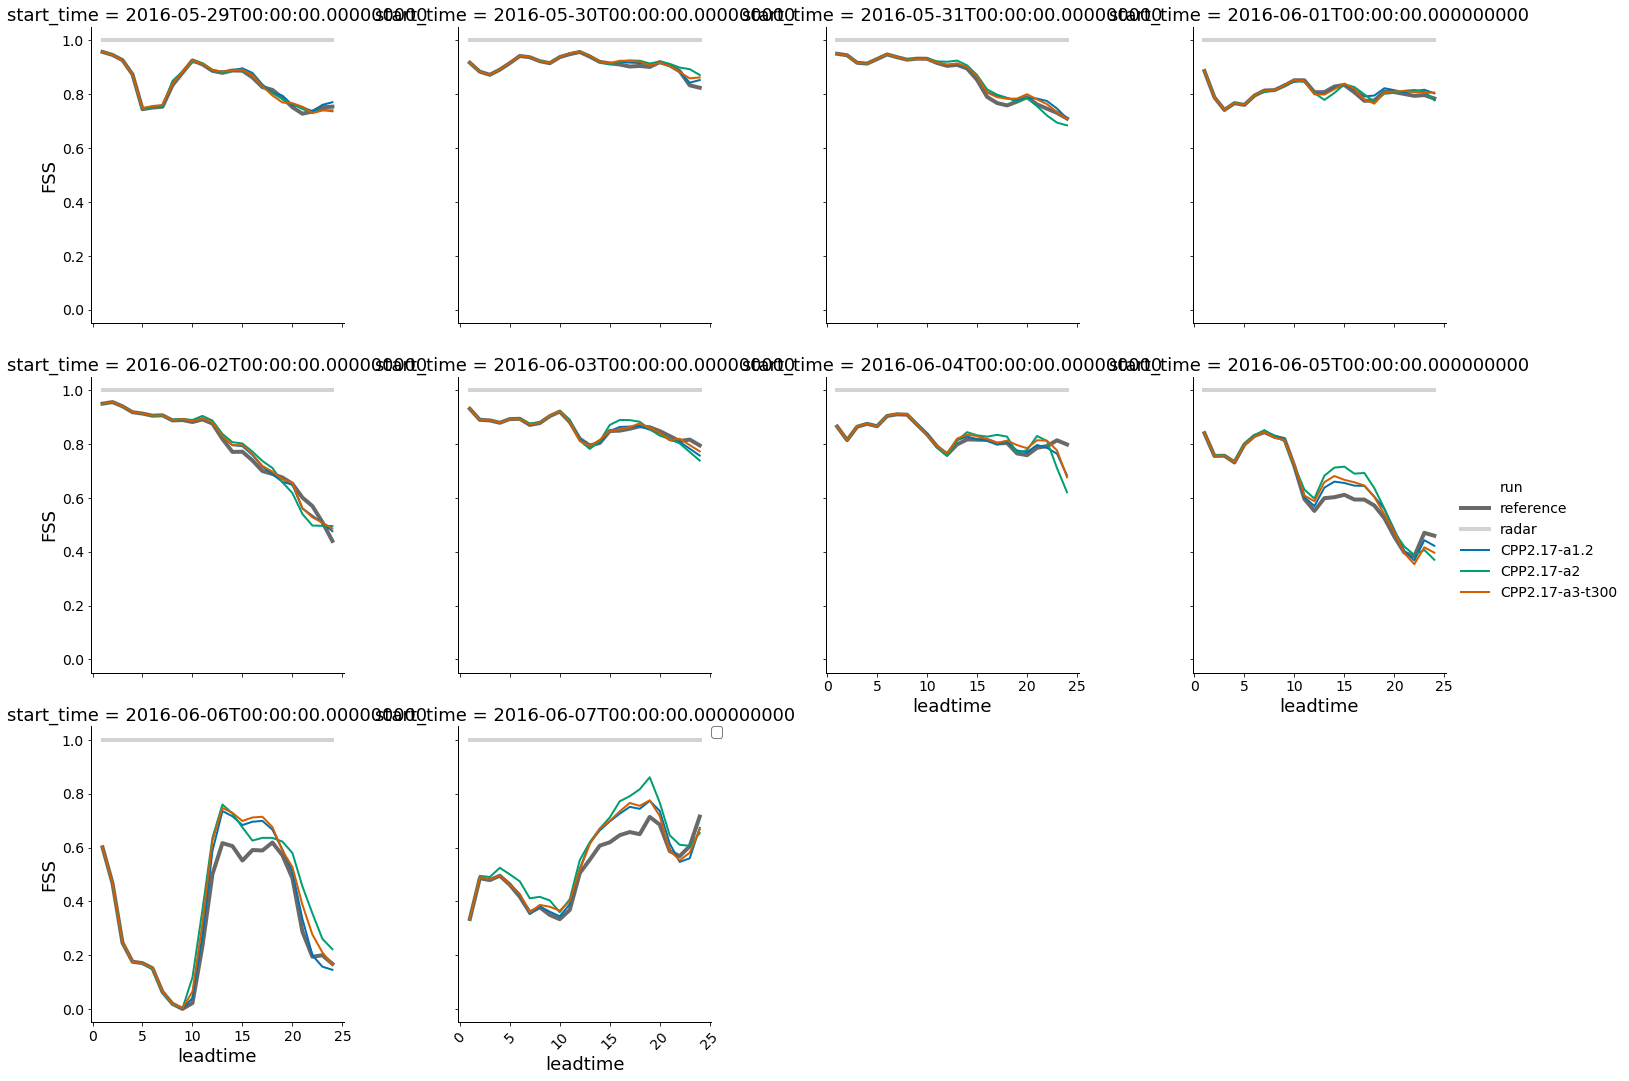

In [75]:

sns.relplot(data = fss_df[(fss_df.threshold == .1)  & (fss_df.scale == 81) & fss_df.run.isin(selected_run_list)], 
            x = 'leadtime', y = 'FSS', hue = 'run',   hue_order=selected_run_list, 
             palette=colors, legend='brief', size= 'run',  kind = 'line', col = 'start_time', col_wrap = 4, sizes=lws)
plt.xticks(rotation=45)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
leg.get_frame().set_alpha(0.5)

### S-SAL

In [71]:
from SAL_cosmo_utils import compute_SAL

list_t =[]
prec2 = prec_arrays.where(radar_mask).stack(time = ['start_date', 'leadtime'])
for ti, t in enumerate(tqdm(prec2.time)):
    prec_sel = prec2.sel(time=t)
    prec_sel = prec_sel.where(prec_sel>0)
    obs = prec_sel['radar'].values
    SAL_df = pd.DataFrame(index=selected_run_list[0:],        
                      columns=('S', 'A', 'L', 'L1', 'L2',
                               'Nobj_obs', 'Nobj_mod', 'R_max',
                               'threshold_obs','threshold_fcst'))    
    
    for irun, run_name in enumerate(selected_run_list[0:]):
        fcst = prec_sel[run_name].values
        SAL_df.iloc[irun]= np.asarray(compute_SAL(obs, fcst))#,user_threshold=0.4))
    SAL_df['time'] = t.values
    list_t.append(SAL_df)
SAL_df = pd.concat(list_t)
SAL_df[['start_time', 'leadtime']] = pd.DataFrame(SAL_df['time'].tolist(), index=SAL_df.index)

100%|██████████| 240/240 [03:57<00:00,  1.16it/s]


In [72]:

SAL_df = SAL_df.reset_index().rename({'index':'run'},axis=1)

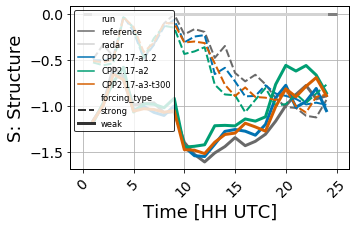

In [73]:
SAL_df['forcing_type']=None
SAL_df.loc[SAL_df.start_time<'2016-06-03', 'forcing_type']='strong'
SAL_df.loc[SAL_df.start_time>='2016-06-03', 'forcing_type']='weak'

colors, lws = get_color_and_lw(selected_run_list[:], prec_arrays)

plt.figure(figsize=[5,3])
sns.lineplot(data = SAL_df[SAL_df.run.isin(selected_run_list)].fillna(0), x = 'leadtime', y = 'S', hue = 'run',   hue_order=selected_run_list[:], 
             palette=colors, legend='brief', size= 'forcing_type', sizes=[2,3],
             style='forcing_type',
             style_order = ['weak', 'strong'],
             estimator=np.mean, ci =None)
plt.xticks(rotation=45) 
#leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg.get_frame().set_alpha(0.5)

leg = plt.legend(loc='upper left' , ncol=1, fontsize='small')
leg.get_frame().set_alpha(0.8)
#leg = plt.legend(bbox_to_anchor=(1.01, 1.15), loc=2, borderaxespad=0.,)
plt.xticks(rotation=45)
plt.ylabel(r'S: Structure')
plt.xlabel('Time [HH UTC]')
plt.grid()
plt.hlines(0,25,0, color='grey', linewidth=3)
##plt.title('threshold = %.1f mm/h'%( SAL_df['threshold_fcst'][0]), fontsize='x-large')
plt.savefig('../Figures/Paper/whole_period_SSAL_ts.pdf',bbox_inches='tight')

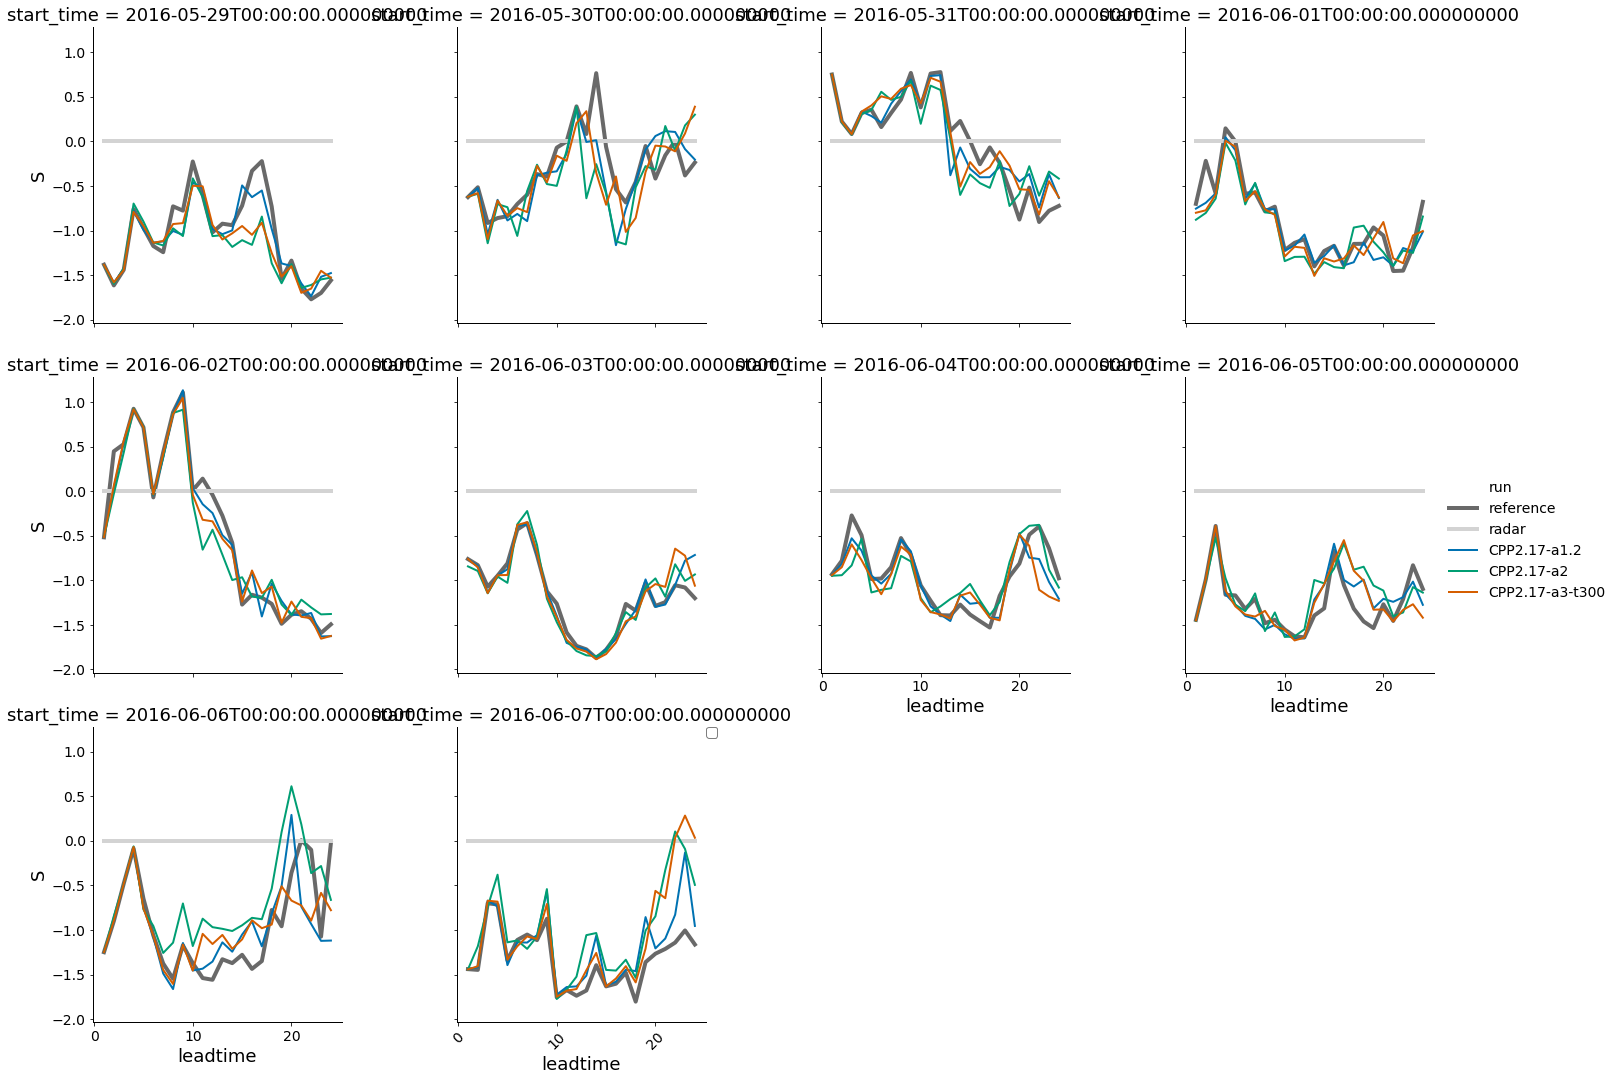

In [74]:

sns.relplot(data = SAL_df[SAL_df.run.isin(selected_run_list)].fillna(0), 
            x = 'leadtime', y = 'S', hue = 'run',   hue_order=selected_run_list, 
             palette=colors, legend='brief', size= 'run',  kind = 'line', col = 'start_time', col_wrap = 4, sizes=lws)
plt.xticks(rotation=45)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
leg.get_frame().set_alpha(0.5)

### Cell numbers and sizes (prec threshold=1, ...)

#### Separated clouds (use watershed)

In [76]:
from rdf_functions import identify_clouds


def identify_clouds_2(*args, return_var='labels', **kwargs):
    args = list(args)
    args[0] = args[0].squeeze()
    args = tuple(args)

    labels, cld_size, cld_sum = identify_clouds(*args, **kwargs)

    labels = xr.DataArray(labels, name='labels', dims=args[0].dims,
                          coords=args[0].coords)
    cld_size = xr.DataArray(cld_size, name='cloud_size', dims=dict(
        cloud_number=np.arange(0, len(cld_size))),
                            coords=dict(
                                cloud_number=np.arange(0, len(cld_size))))
    cld_sum = xr.DataArray(cld_sum, name='cloud_size', dims=dict(
        cloud_number=np.arange(0, len(cld_sum))),
                           coords=dict(
                               cloud_number=np.arange(0, len(cld_sum))))
    cloud_ds = xr.Dataset()
    cloud_ds['labels'] = labels
    cloud_ds['cloud_size'] = cld_size
    cloud_ds['cloud_sum'] = cld_sum
    cloud_ds['cloud_radius'] = np.sqrt(
        cloud_ds.cloud_size / np.pi) / 1000  # in km


    return (cloud_ds)
    

In [77]:
water_kws = dict(water=True, neighborhood=3)
egg = prec_arrays.where(radar_mask).compute().to_array(
    dim='run', name='precipitation').stack(time_run=['leadtime', 'start_date', 'run'])
cloud_ds = egg.groupby('time_run').apply(identify_clouds_2,
                                args=(1.0,), **water_kws)
cloud_ds = cloud_ds.unstack().rename_vars(
     {'time_run_level_0': 'leadtime', 'time_run_level_1': 'start_date',
     'time_run_level_2': 'run'})
cloud_ds = cloud_ds.rename_dims(
     {'time_run_level_0': 'leadtime', 'time_run_level_1': 'start_date',
     'time_run_level_2': 'run'})
cloud_ds['#_of_clouds'] = (cloud_ds.cloud_size > 0).sum('cloud_number')

cloud_ds_sep = cloud_ds.copy()

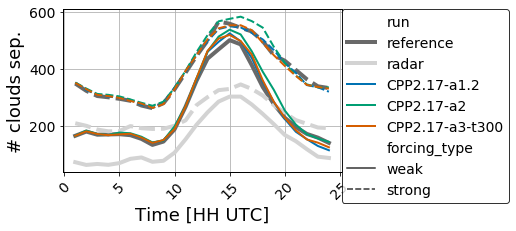

In [82]:
colors, lws = get_color_and_lw(selected_run_list, prec_arrays)


plt.figure(figsize=[5,3])
cloud_df = cloud_ds_sep['#_of_clouds'].to_dataframe().reset_index()
cloud_df['forcing_type']=None
cloud_df.loc[cloud_df.start_date<'2016-06-03', 'forcing_type']='strong'
cloud_df.loc[cloud_df.start_date>='2016-06-03', 'forcing_type']='weak'

sns.lineplot(x = 'leadtime', y = '#_of_clouds',
            hue='run',style= 'forcing_type', palette=colors, legend='brief', size= 'run', sizes=lws,
             hue_order=selected_run_list,size_order=selected_run_list,
             style_order = ['weak', 'strong'],
             data = cloud_df[cloud_df['run'].isin(selected_run_list)],ci=None)

leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel(r'# clouds sep.')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.savefig('../../Thesis/Figures/CPPERT/whole_period_nclouds_sep_ts.pdf',bbox_inches='tight')

Text(0.5, 1.0, 'separated clouds')

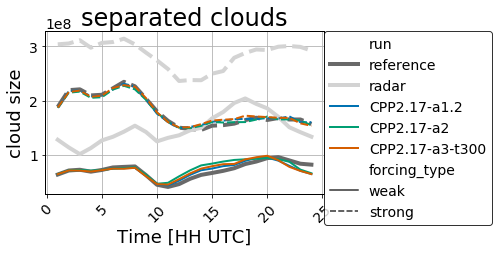

In [83]:
colors, linewidths = get_color_and_lw(selected_run_list, prec_arrays)
df = cloud_ds_sep['cloud_size'].to_dataframe().reset_index()
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>'2016-06-03', 'forcing_type']='weak'

plt.figure(figsize=[5,3])
sns.lineplot(data = df, x = 'leadtime', y = 'cloud_size', hue='run', style='forcing_type',
             hue_order=selected_run_list, palette=colors, 
             style_order = ['weak', 'strong'],
             size='run', sizes= linewidths, size_order=selected_run_list, 
            ci=None)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel(r'cloud size')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
plt.title('separated clouds')

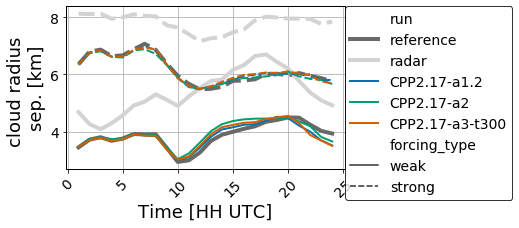

In [84]:
colors, linewidths = get_color_and_lw(selected_run_list, prec_arrays)
df = cloud_ds_sep['cloud_radius'].to_dataframe().reset_index()
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>'2016-06-03', 'forcing_type']='weak'

plt.figure(figsize=[5,3])
sns.lineplot(data = df, x = 'leadtime', y = 'cloud_radius', hue='run', style='forcing_type',
             hue_order=selected_run_list, palette=colors, 
             style_order = ['weak', 'strong'],
             size='run', sizes= linewidths, size_order=selected_run_list, 
            ci=None)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel('cloud radius \nsep. [km]')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.title('separated clouds')
#plt.savefig('../../Thesis/Figures/CPPERT/whole_period_cloudradius_sep_ts.pdf',bbox_inches='tight')

<Figure size 360x216 with 0 Axes>

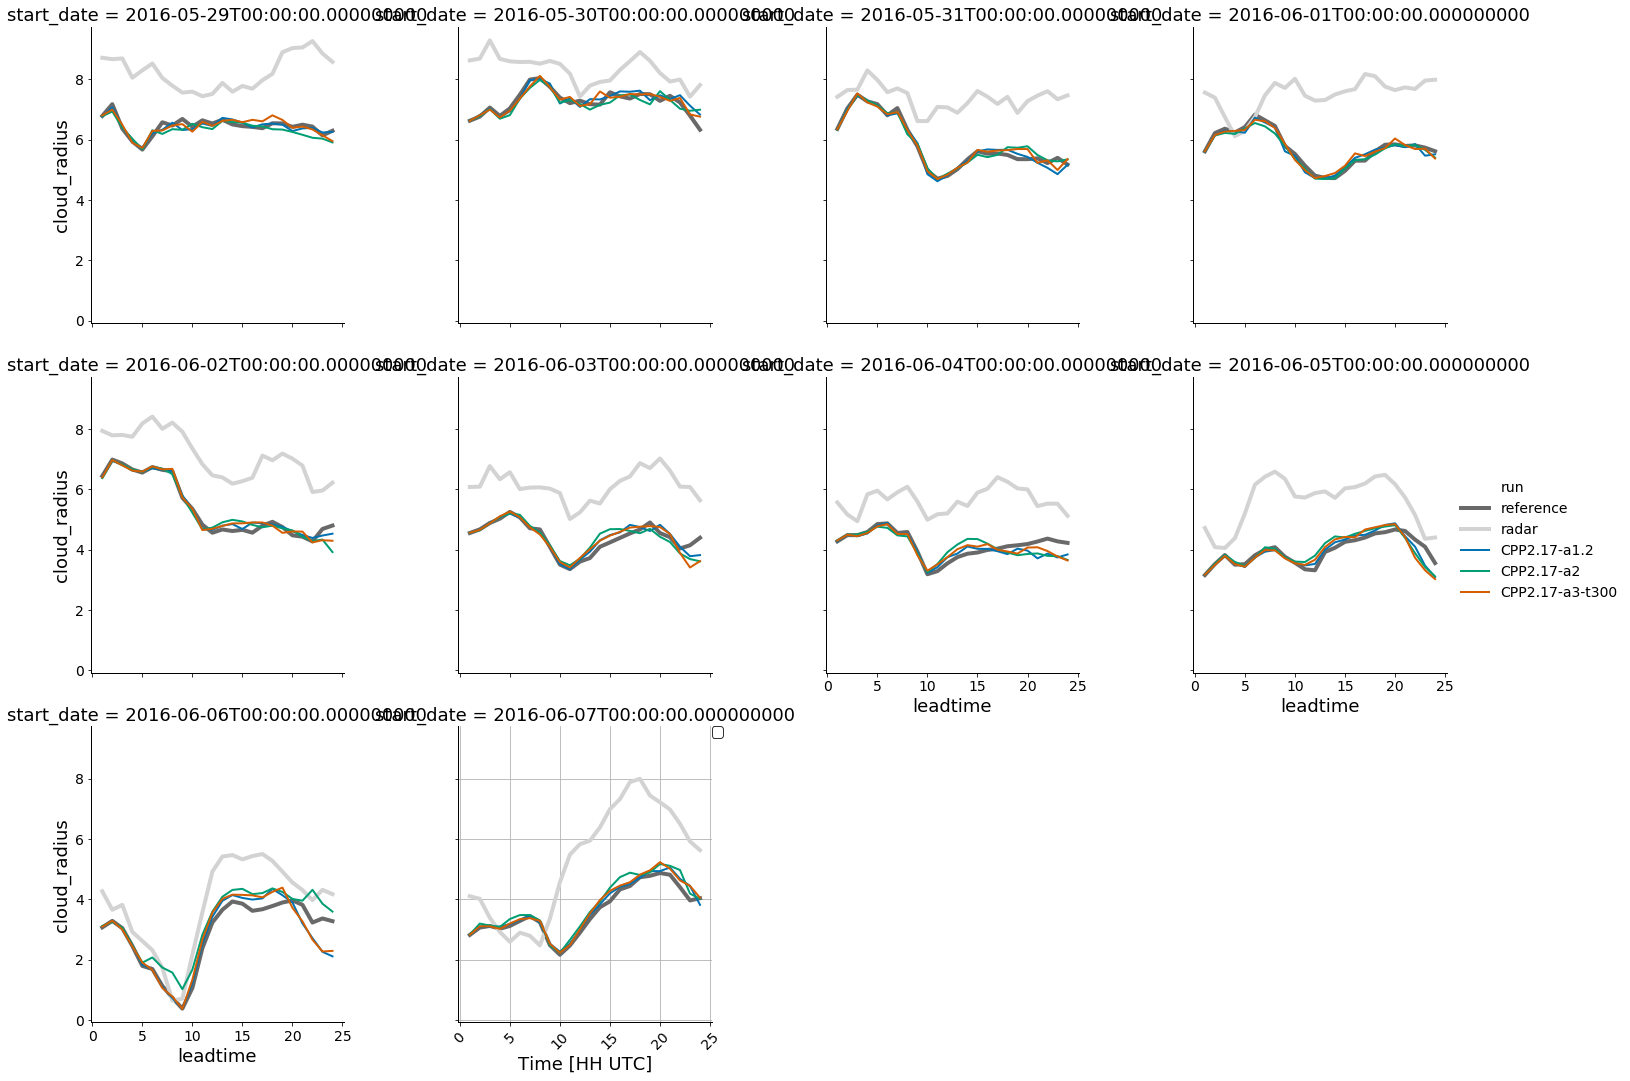

In [85]:
colors, linewidths = get_color_and_lw(selected_run_list, prec_arrays)
df = cloud_ds_sep['cloud_radius'].to_dataframe().reset_index()
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>'2016-06-03', 'forcing_type']='weak'

plt.figure(figsize=[5,3])
sns.relplot(data = df, x = 'leadtime', y = 'cloud_radius', hue='run',#estimator=np.median,
             hue_order=selected_run_list, palette=colors, 
             col='start_date', col_wrap=4, kind='line',
             size='run', sizes= linewidths, size_order=selected_run_list, 
            ci=None)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel('cloud radius \nsep. [km]')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.title('separated clouds')
#plt.savefig('../../Thesis/Figures/CPPERT/whole_period_cloudradius_sep_ts.pdf',bbox_inches='tight')

#### Unseparated clouds (no watershed)

In [ ]:
water_kws= dict(water=False, neighborhood = 5)
egg = prec_arrays.where(radar_mask).compute().to_array(
    dim='run', name='precipitation').stack(time_run=['leadtime', 'start_date', 'run'])
cloud_ds = egg.groupby('time_run').apply(identify_clouds_2,
                                args=(1.0,), **water_kws)
cloud_ds = cloud_ds.unstack().rename_vars(
     {'time_run_level_0': 'leadtime', 'time_run_level_1': 'start_date',
     'time_run_level_2': 'run'})
cloud_ds = cloud_ds.rename_dims(
     {'time_run_level_0': 'leadtime', 'time_run_level_1': 'start_date',
     'time_run_level_2': 'run'})
cloud_ds['#_of_clouds'] = (cloud_ds.cloud_size > 0).sum('cloud_number')

cloud_ds_unsep = cloud_ds.copy()

In [ ]:
x= cloud_ds.cloud_radius.median(['cloud_number'])
y = cloud_ds['#_of_clouds'] #.cloud_radius.mean(['cloud_number'])
x = x.to_dataframe()['cloud_radius']#.reset_index()
y = y.to_dataframe()['#_of_clouds']#.reset_index()
egg =pd.concat([x,y],axis=1).reset_index()

In [ ]:

sns.boxplot(data=egg[egg.run.isin(selected_run_list)], x = 'cloud_radius', y='#_of_clouds', hue='run', alpha=0.8,palette='tab20', 
               style='run',markers= ['.']*8)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )

In [ ]:
colors, lws = get_color_and_lw(selected_run_list, prec_arrays)


plt.figure(figsize=[5,3])
cloud_df = cloud_ds_unsep['cloud_radius'].to_dataframe().reset_index()
cloud_df['forcing_type']=None
cloud_df.loc[cloud_df.start_date<'2016-06-03', 'forcing_type']='strong'
cloud_df.loc[cloud_df.start_date>='2016-06-03', 'forcing_type']='weak'
#cloud_df.set_index(['run','start_date','cloud_number','leadtime']).unstack('run').hist()
#plt.yscale('log')
#plt.ylim([0,20])

In [ ]:
selected_run_list =['reference', 'CPP2.17-a1.2']
colors, lws = get_color_and_lw(selected_run_list, prec_arrays)


fig =plt.figure(figsize=[5,3])
cloud_df = cloud_ds_sep['cloud_radius'].to_dataframe().reset_index()
cloud_df['forcing_type']=None
cloud_df.loc[cloud_df.start_date<'2016-06-03', 'forcing_type']='strong'
cloud_df.loc[cloud_df.start_date>='2016-06-03', 'forcing_type']='weak'


for i,run in enumerate(selected_run_list):
#    egg =(cloud_df.cloud_radius[(cloud_df.run==run) & (cloud_df.forcing_type=='strong')])
#    sns.distplot(egg.where(egg>0.001).dropna(),bins=np.arange(0.01,20,2), kde=False, color=colors[i],
#                  hist_kws={"histtype": "step", "linewidth": 2, "alpha":1}, norm_hist=True)
    
    egg =(cloud_df.cloud_radius[(cloud_df.run==run) & (cloud_df.forcing_type=='weak')])
    n, bins, patches = plt.hist(egg.where(egg>0.001).dropna(),bins =np.arange(0.01,15,1),
                                density=True, histtype='step',color='w',
                           cumulative=True, label='Empirical')
    plt.plot(n,color=colors[i], linewidth=lws[i], linestyle='--')
    
    #sns.distplot(egg.where(egg>0.001).dropna(),bins=np.arange(0.01,20,2), kde=True, color=colors[i],
    #              hist_kws={"histtype": "step", "linewidth": 3, "alpha":1, 'linestyle':'--'})

#plt.yscale('log')
#lt.xlim([0,20])

In [ ]:
egg

In [ ]:
colors, lws = get_color_and_lw(selected_run_list, prec_arrays)


plt.figure(figsize=[5,3])
cloud_df = cloud_ds_unsep['#_of_clouds'].to_dataframe().reset_index()
cloud_df['forcing_type']=None
cloud_df.loc[cloud_df.start_date<'2016-06-03', 'forcing_type']='strong'
cloud_df.loc[cloud_df.start_date>='2016-06-03', 'forcing_type']='weak'

sns.lineplot(x = 'leadtime', y = '#_of_clouds',
            hue='run',style= 'forcing_type', palette=colors, legend='brief', size= 'run', sizes=lws,
             hue_order=selected_run_list,size_order=selected_run_list,
             style_order = ['weak', 'strong'],
             data = cloud_df[cloud_df['run'].isin(selected_run_list)],ci=None)

leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel(r'# clouds non-sep.')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.title('unseparated clouds')
#plt.savefig('../../Thesis/Figures/CPPERT/whole_period_nclouds_unsep_ts.pdf',bbox_inches='tight')

In [ ]:
colors, linewidths = get_color_and_lw(selected_run_list, prec_arrays)
df = cloud_ds_unsep['cloud_radius'].to_dataframe().reset_index()
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>'2016-06-03', 'forcing_type']='weak'

plt.figure(figsize=[5,3])
sns.lineplot(data = df, x = 'leadtime', y = 'cloud_radius', hue='run', style='forcing_type',
             hue_order=selected_run_list, palette=colors,
             style_order = ['weak', 'strong'],
             size='run', sizes= linewidths, size_order=selected_run_list, ci =None)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel('cloud radius \nnon-sep. [km]')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.title('unseparated clouds')
#plt.ylim([0,6])
#plt.ylim([0,1.5*10**9])
#plt.savefig('../../Thesis/Figures/CPPERT/whole_period_cloudradius_unsep_ts.pdf',bbox_inches='tight')

In [ ]:
colors, linewidths = get_color_and_lw(selected_run_list, prec_arrays)
df = cloud_ds_sep['cloud_radius'].to_dataframe().reset_index()
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>'2016-06-03', 'forcing_type']='weak'

plt.figure(figsize=[5,3])
sns.relplot(data = df, x = 'leadtime', y = 'cloud_radius', hue='run',#estimator=np.median,
             hue_order=selected_run_list, palette=colors, 
             col='start_date', col_wrap=4, kind='line',
             size='run', sizes= linewidths, size_order=selected_run_list, 
            ci=None)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel('cloud radius \nnon-sep. [km]')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.title('separated clouds')
#plt.savefig('../../Thesis/Figures/CPPERT/whole_period_cloudradius_sep_ts.pdf',bbox_inches='tight')

### Cell numbers and sizes (prec threshold=5, ...)

#### cloud distributions: sizes, numbers, ...

In [ ]:
from rdf_functions import identify_clouds


def identify_clouds_2(*args, return_var='labels', **kwargs):
    args = list(args)
    args[0] = args[0].squeeze()
    args = tuple(args)

    labels, cld_size, cld_sum = identify_clouds(*args, **kwargs)

    labels = xr.DataArray(labels, name='labels', dims=args[0].dims,
                          coords=args[0].coords)
    cld_size = xr.DataArray(cld_size, name='cloud_size', dims=dict(
        cloud_number=np.arange(0, len(cld_size))),
                            coords=dict(
                                cloud_number=np.arange(0, len(cld_size))))
    cld_sum = xr.DataArray(cld_sum, name='cloud_size', dims=dict(
        cloud_number=np.arange(0, len(cld_sum))),
                           coords=dict(
                               cloud_number=np.arange(0, len(cld_sum))))
    cloud_ds = xr.Dataset()
    cloud_ds['labels'] = labels
    cloud_ds['cloud_size'] = cld_size
    cloud_ds['cloud_sum'] = cld_sum
    cloud_ds['cloud_radius'] = np.sqrt(
        cloud_ds.cloud_size / np.pi) / 1000  # in km


    return (cloud_ds)
    

In [ ]:
water_kws = dict(water=True, neighborhood=3)
egg = prec_arrays.where(radar_mask).compute().to_array(
    dim='run', name='precipitation').stack(time_run=['leadtime', 'start_date', 'run'])
cloud_ds = egg.groupby('time_run').apply(identify_clouds_2,
                                args=(5.0,), **water_kws)
cloud_ds = cloud_ds.unstack().rename_vars(
     {'time_run_level_0': 'leadtime', 'time_run_level_1': 'start_date',
     'time_run_level_2': 'run'})
cloud_ds = cloud_ds.rename_dims(
     {'time_run_level_0': 'leadtime', 'time_run_level_1': 'start_date',
     'time_run_level_2': 'run'})
cloud_ds['#_of_clouds'] = (cloud_ds.cloud_size > 0).sum('cloud_number')

cloud_ds_sep = cloud_ds.copy()

In [ ]:
selected_run_list =  ['reference', 
    
                      'CPP2.17-a1.2',
                      'CPP2.17-a2',
                      #'CPP2.17-a3-t300',

                      r'PSP2 ($\alpha=0.8$) + CPP',
                      #r'PSP2 ($\alpha=0.8$) + CPPa0.8',
                      #r'PSP2 ($\alpha=1$) + CPPa1',
                      #r'PSP ($\alpha=4$) + CPP',
                      #r'PSP2 ($\alpha=1.5$)',
                      'radar'
                     ]



In [ ]:
colors, lws = get_color_and_lw(selected_run_list, prec_arrays)


plt.figure(figsize=[5,3])
cloud_df = cloud_ds_sep['#_of_clouds'].to_dataframe().reset_index()
cloud_df['forcing_type']=None
cloud_df.loc[cloud_df.start_date<'2016-06-03', 'forcing_type']='strong'
cloud_df.loc[cloud_df.start_date>='2016-06-03', 'forcing_type']='weak'

sns.lineplot(x = 'leadtime', y = '#_of_clouds',
            hue='run',style= 'forcing_type', palette=colors, legend='brief', size= 'run', sizes=lws,
             hue_order=selected_run_list,size_order=selected_run_list,
             style_order = ['weak', 'strong'],
             data = cloud_df[cloud_df['run'].isin(selected_run_list)],ci=None)

leg = plt.legend(bbox_to_anchor=(1.01, 1.01), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel(r'# clouds sep.')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
plt.savefig('../Figures/Paper/whole_period_nclouds_p5_sep_ts.pdf',bbox_inches='tight')

In [ ]:
colors, linewidths = get_color_and_lw(selected_run_list, prec_arrays)
df = cloud_ds_sep['cloud_radius'].to_dataframe().reset_index()
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>'2016-06-03', 'forcing_type']='weak'

plt.figure(figsize=[5,3])
sns.lineplot(data = df, x = 'leadtime', y = 'cloud_radius', hue='run', style='forcing_type',#estimator=np.median,
             hue_order=selected_run_list, palette=colors, 
             style_order = ['weak', 'strong'],
             size='run', sizes= linewidths, size_order=selected_run_list, 
            ci=None)
leg = plt.legend(bbox_to_anchor=(1.01, 1.01), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel('cloud radius \nsep. [km]')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.title('separated clouds')
plt.savefig('../Figures/Paper/whole_period_cloudradius_p5_sep_ts.pdf',bbox_inches='tight')

In [ ]:
colors, linewidths = get_color_and_lw(selected_run_list, prec_arrays)
df = cloud_ds_sep['cloud_radius'].to_dataframe().reset_index()
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>'2016-06-03', 'forcing_type']='weak'

plt.figure(figsize=[5,3])
sns.relplot(data = df, x = 'leadtime', y = 'cloud_radius', hue='run',#estimator=np.median,
             hue_order=selected_run_list, palette=colors, 
             col='start_date', col_wrap=4, kind='line',
             size='run', sizes= linewidths, size_order=selected_run_list, 
            ci=None)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel('cloud radius \nsep. [km]')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.title('separated clouds')
#plt.savefig('../../Thesis/Figures/CPPERT/whole_period_cloudradius_sep_ts.pdf',bbox_inches='tight')

In [ ]:
selected_run_list =['reference', 'CPP2.17-a1.2','CPP2.17-a2']
colors, lws = get_color_and_lw(selected_run_list, prec_arrays)


fig =plt.figure(figsize=[5,3])
cloud_df = cloud_ds_sep['cloud_radius'].to_dataframe().reset_index()
cloud_df['forcing_type']=None
cloud_df.loc[cloud_df.start_date<'2016-06-03', 'forcing_type']='strong'
cloud_df.loc[cloud_df.start_date>='2016-06-03', 'forcing_type']='weak'


for i,run in enumerate(selected_run_list):
#    egg =(cloud_df.cloud_radius[(cloud_df.run==run) & (cloud_df.forcing_type=='strong')])
#    sns.distplot(egg.where(egg>0.001).dropna(),bins=np.arange(0.01,20,2), kde=False, color=colors[i],
#                  hist_kws={"histtype": "step", "linewidth": 2, "alpha":1}, norm_hist=True)
    
    egg =(cloud_df.cloud_radius[(cloud_df.run==run) & (cloud_df.forcing_type=='weak')])
    n, bins, patches = plt.hist(egg.where(egg>0.001).dropna(),bins =np.arange(0.01,15,1),
                                density=True, histtype='step',color='w',
                           cumulative=True, label='Empirical')
    plt.plot(n,color=colors[i], linewidth=lws[i], linestyle='--')
    
    #sns.distplot(egg.where(egg>0.001).dropna(),bins=np.arange(0.01,20,2), kde=True, color=colors[i],
    #              hist_kws={"histtype": "step", "linewidth": 3, "alpha":1, 'linestyle':'--'})

#plt.yscale('log')
#lt.xlim([0,20])

#### unseparated clouds

In [ ]:
water_kws= dict(water=False, neighborhood = 5)
egg = prec_arrays.where(radar_mask).compute().to_array(
    dim='run', name='precipitation').stack(time_run=['leadtime', 'start_date', 'run'])
cloud_ds = egg.groupby('time_run').apply(identify_clouds_2,
                                args=(5.0,), **water_kws)
cloud_ds = cloud_ds.unstack().rename_vars(
     {'time_run_level_0': 'leadtime', 'time_run_level_1': 'start_date',
     'time_run_level_2': 'run'})
cloud_ds = cloud_ds.rename_dims(
     {'time_run_level_0': 'leadtime', 'time_run_level_1': 'start_date',
     'time_run_level_2': 'run'})
cloud_ds['#_of_clouds'] = (cloud_ds.cloud_size > 0).sum('cloud_number')

cloud_ds_unsep = cloud_ds.copy()

In [ ]:
selected_run_list =['reference', 'CPP2.17-a1.2','CPP2.17-a2']
colors, lws = get_color_and_lw(selected_run_list, prec_arrays)


fig =plt.figure(figsize=[5,3])
cloud_df = cloud_ds_unsep['cloud_radius'].to_dataframe().reset_index()
cloud_df['forcing_type']=None
cloud_df.loc[cloud_df.start_date<'2016-06-03', 'forcing_type']='strong'
cloud_df.loc[cloud_df.start_date>='2016-06-03', 'forcing_type']='weak'


for i,run in enumerate(selected_run_list):
#    egg =(cloud_df.cloud_radius[(cloud_df.run==run) & (cloud_df.forcing_type=='strong')])
#    sns.distplot(egg.where(egg>0.001).dropna(),bins=np.arange(0.01,20,2), kde=False, color=colors[i],
#                  hist_kws={"histtype": "step", "linewidth": 2, "alpha":1}, norm_hist=True)
    
    egg =(cloud_df.cloud_radius[(cloud_df.run==run) & (cloud_df.forcing_type=='weak')])
    n, bins, patches = plt.hist(egg.where(egg>0.001).dropna(),bins =np.arange(0.01,15,1),
                                density=False, histtype='step',color='w',
                           cumulative=True, label='Empirical')
    plt.plot(n,color=colors[i], linewidth=lws[i], linestyle='--')
    
    #sns.distplot(egg.where(egg>0.001).dropna(),bins=np.arange(0.01,20,2), kde=True, color=colors[i],
    #              hist_kws={"histtype": "step", "linewidth": 3, "alpha":1, 'linestyle':'--'})

#plt.yscale('log')
#lt.xlim([0,20])

In [ ]:
colors, lws = get_color_and_lw(selected_run_list, prec_arrays)


plt.figure(figsize=[5,3])
cloud_df = cloud_ds_unsep['#_of_clouds'].to_dataframe().reset_index()
cloud_df['forcing_type']=None
cloud_df.loc[cloud_df.start_date<'2016-06-03', 'forcing_type']='strong'
cloud_df.loc[cloud_df.start_date>='2016-06-03', 'forcing_type']='weak'

sns.lineplot(x = 'leadtime', y = '#_of_clouds',
            hue='run',style= 'forcing_type', palette=colors, legend='brief', size= 'run', sizes=lws,
             hue_order=selected_run_list,size_order=selected_run_list,
             style_order = ['weak', 'strong'],
             data = cloud_df[cloud_df['run'].isin(selected_run_list)],ci=None)

leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel(r'# clouds non-sep.')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.title('unseparated clouds')
#plt.savefig('../../Thesis/Figures/CPPERT/whole_period_nclouds_unsep_ts.pdf',bbox_inches='tight')

In [ ]:
colors, linewidths = get_color_and_lw(selected_run_list, prec_arrays)
df = cloud_ds_unsep['cloud_radius'].to_dataframe().reset_index()
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>'2016-06-03', 'forcing_type']='weak'

plt.figure(figsize=[5,3])
sns.lineplot(data = df, x = 'leadtime', y = 'cloud_radius', hue='run', style='forcing_type',
             hue_order=selected_run_list, palette=colors,
             style_order = ['weak', 'strong'],
             size='run', sizes= linewidths, size_order=selected_run_list, ci =None, legend=False)
#leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=2, fontsize='medium')
#leg.get_frame().set_alpha(0.5)
plt.xticks(rotation=45)
plt.ylabel('cloud radius \nnon-sep. [km]')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.title('unseparated clouds')
#plt.ylim([0,6])
#plt.ylim([0,1.5*10**9])
plt.savefig('../Figures/Paper/whole_period_cloudradius_p5_unsep_ts.pdf',bbox_inches='tight')

In [ ]:
colors, linewidths = get_color_and_lw(selected_run_list, prec_arrays)
df = cloud_ds_unsep['cloud_radius'].to_dataframe().reset_index()
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>'2016-06-03', 'forcing_type']='weak'

plt.figure(figsize=[5,3])
sns.relplot(data = df, x = 'leadtime', y = 'cloud_radius', hue='run', 
             hue_order=selected_run_list, palette=colors,
             col='start_date', col_wrap=4, kind='line',
             size='run', sizes= linewidths, size_order=selected_run_list, ci =None)
leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., )
#leg = plt.legend(loc='upper left' , ncol=1, fontsize='medium')
leg.get_frame().set_alpha(0.8)
plt.xticks(rotation=45)
plt.ylabel('cloud radius \nnon-sep. [km]')
plt.xlabel('Time [HH UTC]')
plt.grid()
#plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
#plt.title('unseparated clouds')
#plt.ylim([0,6])
#plt.ylim([0,1.5*10**9])
#plt.savefig('../../Thesis/Figures/CPPERT/whole_period_cloudradius_unsep_ts.pdf',bbox_inches='tight')